# Github Link

The code for this project can be found at: https://github.com/zach-lloyd/colorado_supervised_machine_learning_final_project

# Brief Statement of Problem

I want to gather statistics on NFL players and use them to predict how many points a player will score in fantasy football.

# Brief Fantasy Football Primer

Fantasy football is a game where participants select a team of NFL players via a draft and compete against each other to see whose team can score the most points. There are a variety of different rule systems for awarding points, but the most popular systems award 6 points for each rushing or receiving touchdown, 4 points for each passing touchdown, 0.1 points for each rushing or receiving yard, 0.04 points for each passing yard, and -2 points for each fumble lost or interception. The most popular format is known as "PPR", which stands for "Point Per Reception" and signifies that in addition to awarding points as previously mentioned, this format also awards 1 point for each pass a player catches. Because of its popularity, I used this scoring format to calculate the number of fantasy points a player scores.

A football team is comprised of a variety of different positions across three facets of the game: offense, defense, and special teams. However, fantasy football typically only focuses on the offensive "skill positions" (the positions that most often handle the ball and score points for their team):

    1. Quarterback (responsible for passing and occasionally running the ball)
    2. Running Backs (responsible for running the ball and sometimes catching passes)
    3. Wide Receivers (responsible for catching passes and occasionally running the ball)
    4. Tight Ends (responsible for catching passes, occasionally running the ball, and also blocking with the offensive line)

Because of that, my project focuses on these positions.

# Type of Problem, Models Used, and Goal

Because a player's fantasy points scored is a continuous value, this is a regression problem rather than a classification problem. It would be possible without much additional effort to turn this into a classification problem by, for instance, classifying whether a player finished in the top 10 for their position or not. However, I think fantasy points scored is a more informative metric than a simple classification of player rank, so my project focuses on that metric.

As will be be discussed in more detail in my exploration of the data, a number of the features I used for this project are fairly sparse. Given that, I primarily used a Random Forest model to analyze the data. Additionally, my project concludes by experimenting with an XGBoost model. I don't believe this type of model was discussed in class, but I understand it has gained popularity in the industry, so I wanted to see how its performance compared to the baseline Random Forest model.

Beyond simply predicting fantasy scoring, the goal of my project is to work toward better evaluation of football player performance. Fantasy scoring is strongly correlated with real-life performance, so if we can make strides in understanding what statistics most strongly influence fantasy scoring, we can get better at evaluating and projecting real-life player performance.

# Scraping Player Statistics for Each Season

To being with, I wanted to build a CSV file with passing, rushing, and receiving statistics for as many players as I could find data for. Pro Football Reference has these statistics dating back to the 1932 NFL season, so that's where I scraped this information from.

Citations:

    1. Passing: See, e.g., Pro-Football-Reference.com. (n.d.). 2024 NFL passing statistics [Data set]. Retrieved June 1, 2025, from https://www.pro-football-reference.com/years/2024/passing.htm (passing statistics from other seasons can be accessed by replacing "2024" with the applicable year in this URL).
            
    2. Rushing: See, e.g., Pro-Football-Reference.com. (n.d.). 2024 NFL rushing statistics [Data set]. Retrieved June 1, 2025, from https://www.pro-football-reference.com/years/2024/rushing.htm (rushing statistics from other seasons can be accessed by replacing "2024" with the applicable year in this URL).
            
    3. Receiving: See, e.g., Pro-Football-Reference.com. (n.d.). 2024 NFL receiving statistics [Data set]. Retrieved June 1, 2025, from https://www.pro-football-reference.com/years/2024/receiving.htm (receiving statistics from other seasons can be accessed by replacing "2024" with the applicable year in this URL).

In [ ]:
import os, time, random, requests
import pandas as pd


def get_stats_csv(year, stats_type, output_dir):
    """Gets the specified stats for the specified year and saves them to a CSV file.

    Args:
        year:           An integer representing the season for which you want to fetch stats.
        stats_type:     String representing the type of stats to fetch ('passing', 'rushing',
                        'receiving', 'fantasy', 'kicking', 'return', or 'defense').
        output_dir:     String representing the directory to save the CSV file in.

    Returns:
        Null. Writes the stats sheet to a CSV file and saves it in output_dir.
    
    Raises:
        HTTPError:          URL generates an invalid response.
        RequestException:   Request to Pro Football Reference was unsuccessful.
        ValueError:         Unable to locate the table in the response returned from PFR.
        Exception:          For general errors.

    """
    # Use a header to avoid getting blocked.
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/91.0.4472.124 Safari/537.36'
        )
    }
    # Make sure to use the url of the table itself rather than the url of the page.
    # The response you get from using the url of the table itself is much easier to parse.
    url = f'https://www.pro-football-reference.com/years/{year}/{stats_type}.htm#{stats_type}'

    try:
        response = requests.get(url, headers=headers, timeout=10)
        # Check for errors.
        response.raise_for_status()
        response_text = response.text
        print('Successfully fetched HTML content.')
        # Tables on PFR should typically have an id tag equal to the type of stats stored
        # in the table.
        tables = pd.read_html(response_text, attrs={'id': stats_type})

        if not tables:
            print(f'No table with id={stats_type} found for the year {year} at {url}.')
            print('The page structure might have changed, or data for this year might not be available in the expected format.')
            return
        # Get the first table (there shouldn't be more than one).
        df = tables[0]
        # Add a column reflecting the season that these stats are from.
        df['Season'] = year
        
        print('Successfully parsed the fantasy stats table.')
        # Many columns from PFR are multiindex, so this is needed to flatten them.
        df.columns = flatten_multind_cols(df.columns)
        print('cols flattened')
        # PFR columns sometimes have extraneous characters tacked onto the end of
        # player names. This function will strip those extraneous characters.
        df = clean_player_names(df)
        print('names cleaned')
        # Make sure that integer/float columns are properly converted to numeric
        # values.
        df = convert_to_numeric(df)
        print('converted to numeric')
        # Drop any rows where all the values are NaN.
        df.dropna(how='all', inplace=True)
        print('NaN rows dropped')
        # If the df includes a separate row for the league averages, remove it.
        df.drop(df[df['Player'] == 'League Average'].index, inplace=True)
        # Reset df index after filtering and dorpping rows.
        df.reset_index(drop=True, inplace=True)

        print('Data cleaning complete.')

        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        csv_filename = os.path.join(output_dir, f'{stats_type}_stats_{year}.csv')
        df.to_csv(csv_filename, index=False)

        print(f'Successfully saved data to {csv_filename}')

    except requests.exceptions.HTTPError as e:
        print(f'HTTP error occurred for year {year}: {e}')
        print(f'URL attempted: {url}')

    except requests.exceptions.RequestException as e:
        print(f'Error during HTTP request for year {year}: {e}')

    except ValueError as e:
        # This can happen if pd.read_html fails (e.g., "No tables found" if attrs don't match).
        print(f'Error parsing HTML table for year {year}: {e}')

    except Exception as e:
        print(f'An unexpected error occurred for year {year}: {e}')

Data from Pro Football Reference often includes columns headers that have multiple indices, extraneous characters at the end of player names, and duplicate header rows every 20 or so rows. To head off these potential issues, I defined some data cleaning functions.

In [ ]:
def flatten_multind_cols(cols):
    """Flatten any column names that are multi-indexed.

    Args:
        cols: A list of column names in a Pandas dataframe.
    
    Returns:
        A list of column names with any multi-indexed column names flattened.
    """
    if isinstance(cols, pd.MultiIndex):
        new_cols = []

        for col_tuple in cols:
            # If the first level of the MultiIndex is 'Unnamed: X_level_0' or empty,
            # just use the second level name.
            if 'Unnamed:' in col_tuple[0] or col_tuple[0].strip() == '':
                new_cols.append(col_tuple[1])
            else:
                # Otherwise, combine them. If both levels are the same, just use one.
                if col_tuple[0] == col_tuple[1]:
                    new_cols.append(col_tuple[0])
                else:
                    new_cols.append(f'{col_tuple[0]}_{col_tuple[1]}')

        cols = new_cols
        print('Successfully flattened column headers.')
        
        return new_cols
    else:
        print('No columns need to be flattened.')

        return cols
    

def remove_dup_headers(df):
    """Remove duplicate header rows.

    Args:
        df: A Pandas dataframe containing NFL stats.

    Return:
        A dataframe with any duplicate header rows removed.
    """
    # PFR fantasy tables typically have a 'Rk' column, so can use that to remove
    # duplicate header rows
    if 'Rk' in df.columns:
        # Convert the entire 'Rk' column to strings and then keep only the rows
        # where the rank column only contains digits. If a row has any non-digit
        # characters, it must be a duplicate header row and it can be removed.
        df = df[df['Rk'].astype(str).str.isdigit()]
    else:
        # Handle case where the table doesn't have a 'Rk' column by assuming the
        # first column is the 'Rk' column.
        print("Warning: 'Rk' column not found as expected. Attempting to filter based on the first column.")

        if not df.empty:
            first_col_name = df.columns[0]
            df = df[df[first_col_name].astype(str).str.isdigit()]
    
    return df


def clean_player_names(df):
    """Strip extraneous characters from player names.

    Args:
        df: A Pandas dataframe containing NFL stats.

    Returns:
        A dataframe with extraneous characters removed from the end of player names.
    """
    if 'Player' in df.columns:
        df['Player'] = df['Player'].astype(str).str.replace(r'[*+]', '', regex=True).str.strip()
    
    return df


def convert_to_numeric(df):
    """Convert columns that should be numbers to numeric.
    
    Args:
        df: A Pandas dataframe containing NFL stats.

    Returns:
        A dataframe with all columns that should be numeric converted to numbers.
    """
    for col in df.columns:
        # Skip columns that should remain as text, convert other columns to numbers
        # errors='coerce' changes any non-numeric values in the converted columns to NaN
        if col.lower() not in ['player', 'team', 'pos', 'awards', 'tm', 'fantpos']:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df


The tables I ended up using for scraping passing, rushing, and receiving stats did not actually have duplicate header rows, so I didn't need to call that funciton in the get_stats_csv file, but it still ended up being necessary when I scraped fantasy points scored (see below), so I left it in here.

The following code scrapes and saves passing, rushing, and receiving stats for each season from 1932 to 2024 in separate CSV files.

In [ ]:
start_year = 1932
end_year = 2024
stats_types = ['passing', 'rushing', 'receiving']

for yr in range(start_year, end_year + 1):
    for stat in stats_types: 
        print(f'Starting {stat} stats download for year {yr}...')
        get_stats_csv(yr, stat, f'{stat}_stats')
        print(f'Pausing for a few seconds...')
        # Delay and jitter the PFR requests to avoid getting rate limited.
        time.sleep(random.uniform(5.5, 10.5))

The above code successfully grabbed and saves statistical data for each stat type and season in separate files, like so:
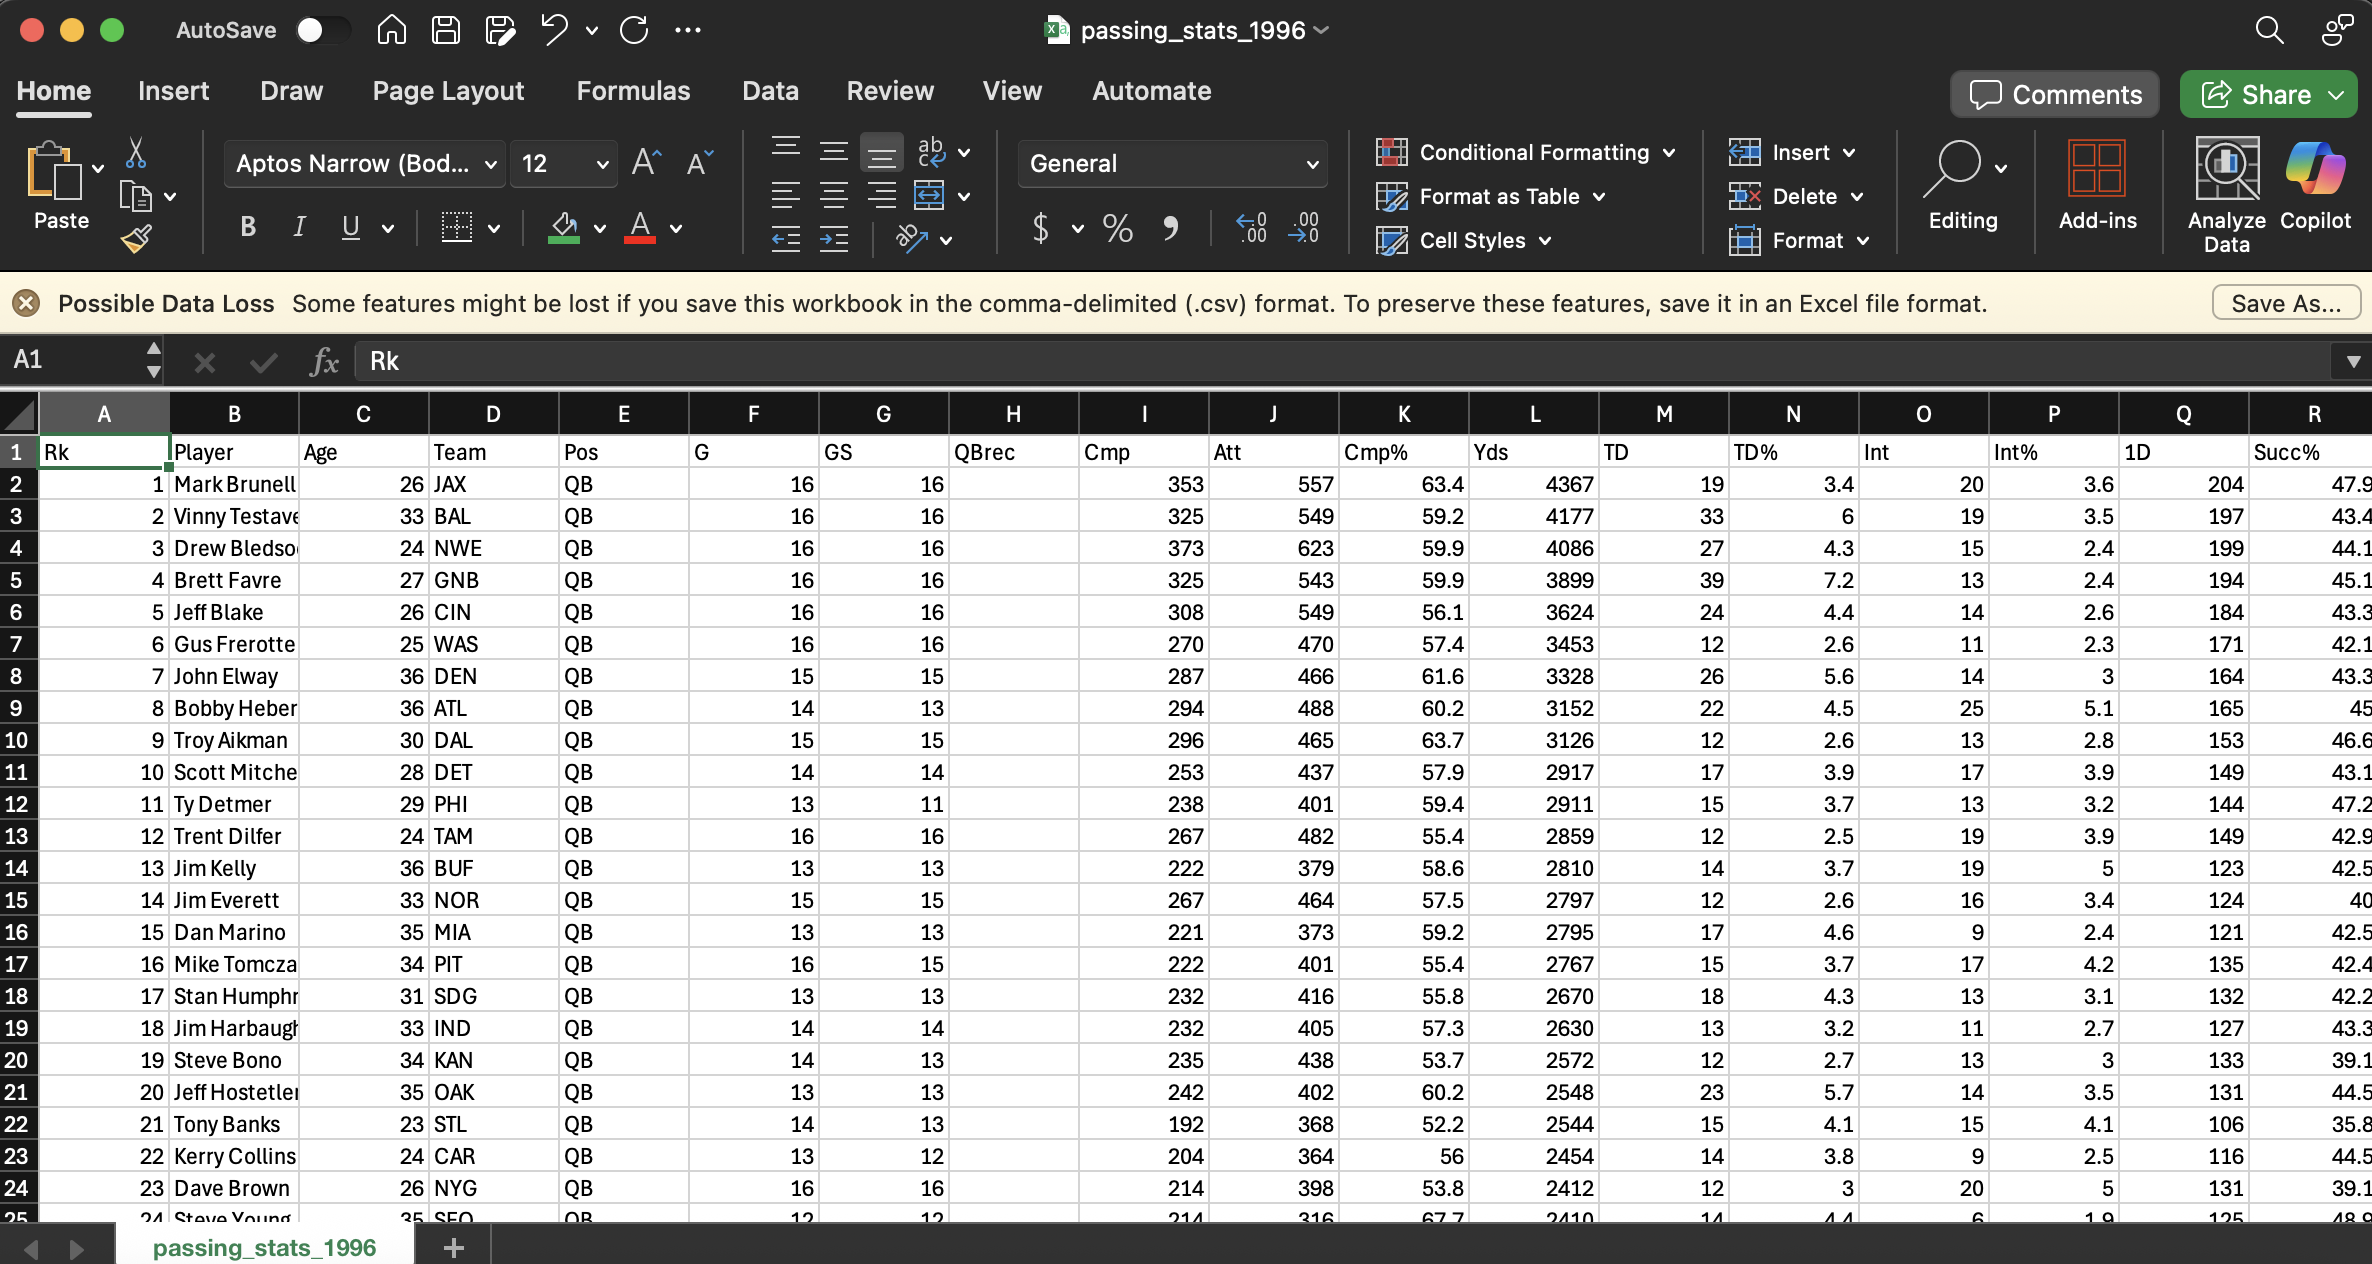

However, I felt like it would be much easier to deal with this data in a single CSV file when building my Random Forest and XGBoost models, so my next step was to write some code that joined these CSV files together.

In [ ]:
from functools import reduce


def remove_duplicates(df):
    """Remove duplicate rows of players who played for more than one team in a season. 

    Args:
        df: A Pandas dataframe with NFL player stats.
    
    Returns:
        A revised version of the dataframe that removes duplicate rows for players who 
        played for more than one team in a single season and keeps just the aggregate 
        row showing their full stats for that season.
    """
    # PFR handles players playing for multiple teams in the same season by listing the 
    # player's stats with each team, as well as their aggregate stats for the season in 
    # a separate row with their team listed as '2TM', '3TM', etc.
    agg_pat   = r"^(?:[234]TM|TOT)$"
    # Track whether a player played for multiple teams in the same year.
    df['is_agg'] = df['Team'].str.match(agg_pat)
    # Sort by is_agg in descending order so for any players who played for more than
    # one team, the aggregate stats row is the first row listed for that player,
    # then drop the other, team-specific rows for that player.
    cleaned_df = (df
         .sort_values('is_agg', ascending=False)      
         .drop_duplicates(subset=['Player', 'Season', 'Pos'], keep='first')
         .drop(columns='is_agg') # Can remove the is_agg column after this.                  
         .reset_index(drop=True))
    
    return cleaned_df


def join_sheets(pass_csv, rush_csv, recv_csv):
    """Joins the passing, rushing, and receiving stat sheets for a given season.

    Args:
        pass_csv: A csv pulled from Pro Football Reference with passing stats from an 
                  NFL season.
        rush_csv: A csv pulled from Pro Football Reference with rushing stats from an 
                  NFL season.
        recv_csv: A csv pulled from Pro Football Reference with receiving stats from an 
                  NFL season.
    
    Returns:
        A Pandas dataframe with the three csv files combined into one sheet.
    """
    pass_df = pd.read_csv(pass_csv)
    rush_df = pd.read_csv(rush_csv)
    recv_df = pd.read_csv(recv_csv)
    # For some reason the Season column in the rushing and receiving tables got
    # added as 'Season_', but the same did not happen in the passing tables.
    rush_df.rename(columns={'Season_': 'Season'}, inplace=True)
    recv_df.rename(columns={'Season_': 'Season'}, inplace=True)

    pass_cols_to_rename = [
        'Att', 'Yds', 'TD', 'TD%', '1D', 'Succ%', 'Lng', 'Y/A', 'AY/A', 'Y/C', 
        'Y/G', 'NY/A', 'ANY/A'
    ]
    # Rename some generically-named columns in the passing dataframe to avoid 
    # confusion. This is not necessary for the rushing and receiving tables
    # because they have column names of the format 'Rushing_{stat}'/'Receiving_{stat}'.
    for col in pass_df.columns:
        if col == 'Yds.1':
            pass_df.rename(columns={col: 'SkYdsLst'}, inplace=True)
        elif col in pass_cols_to_rename:
            pass_df.rename(columns={col: f'Pass_{col}'}, inplace=True)
        else:
            continue

    dfs = [
        remove_duplicates(pass_df), 
        remove_duplicates(rush_df), 
        remove_duplicates(recv_df)
    ]

    keys  = ['Player', 'Season', 'Team', 'Pos', 'Age', 'GS', 'G', 'Awards']
    combined_df  = reduce(lambda left,right: pd.merge(left, right, how='outer', on=keys), dfs)
    # Handle duplicate fumble columns from the rushing and receiving sheets. Joining on 
    # this column doesn't work because the passing sheet doesn't have a Fumbles column.
    if 'Fmb_x' in combined_df.columns:
        combined_df.rename(columns={'Fmb_x': 'Fumbles'}, inplace=True)
        combined_df = combined_df.drop(columns='Fmb_y')
    else:
        combined_df['Fumbles'] = pd.NA
        
    return combined_df

Note that remove_duplicates is another necessary data cleaning function because some players play for more than one team in a particular season. Pro Football Reference handles this by including separate rows showing the player's stats for each team they played for in a given season, as well as an aggregate row showing the player's total stats across all teams for that season. I only want to keep the aggregate row, because including the team-specific rows would amount to include observations that are duplicative of other observations.

The following code uses the above functions to join all of the passing, rushing, and receiving CSVs into one large CSV file that I called "leviathan_stats":

In [ ]:
start_year = 1932
end_year = 2024
sheets = []

for yr in range(start_year, end_year + 1):
    passing_stats = f'passing_stats/passing_stats_{yr}.csv'
    rushing_stats = f'rushing_stats/rushing_stats_{yr}.csv'
    receiving_stats = f'receiving_stats/receiving_stats_{yr}.csv'
    combined_sheet = join_sheets(passing_stats, rushing_stats, receiving_stats)
    sheets.append(combined_sheet)

complete_sheet = pd.concat(sheets, axis=0, ignore_index=True, sort=False)
complete_sheet.to_csv('leviathan_stats.csv', index=False)

After running this code, I now have a sheet with NFL passing, rushing, and receiving stats from 1932 to 2024, with each row representing a single player's season. 

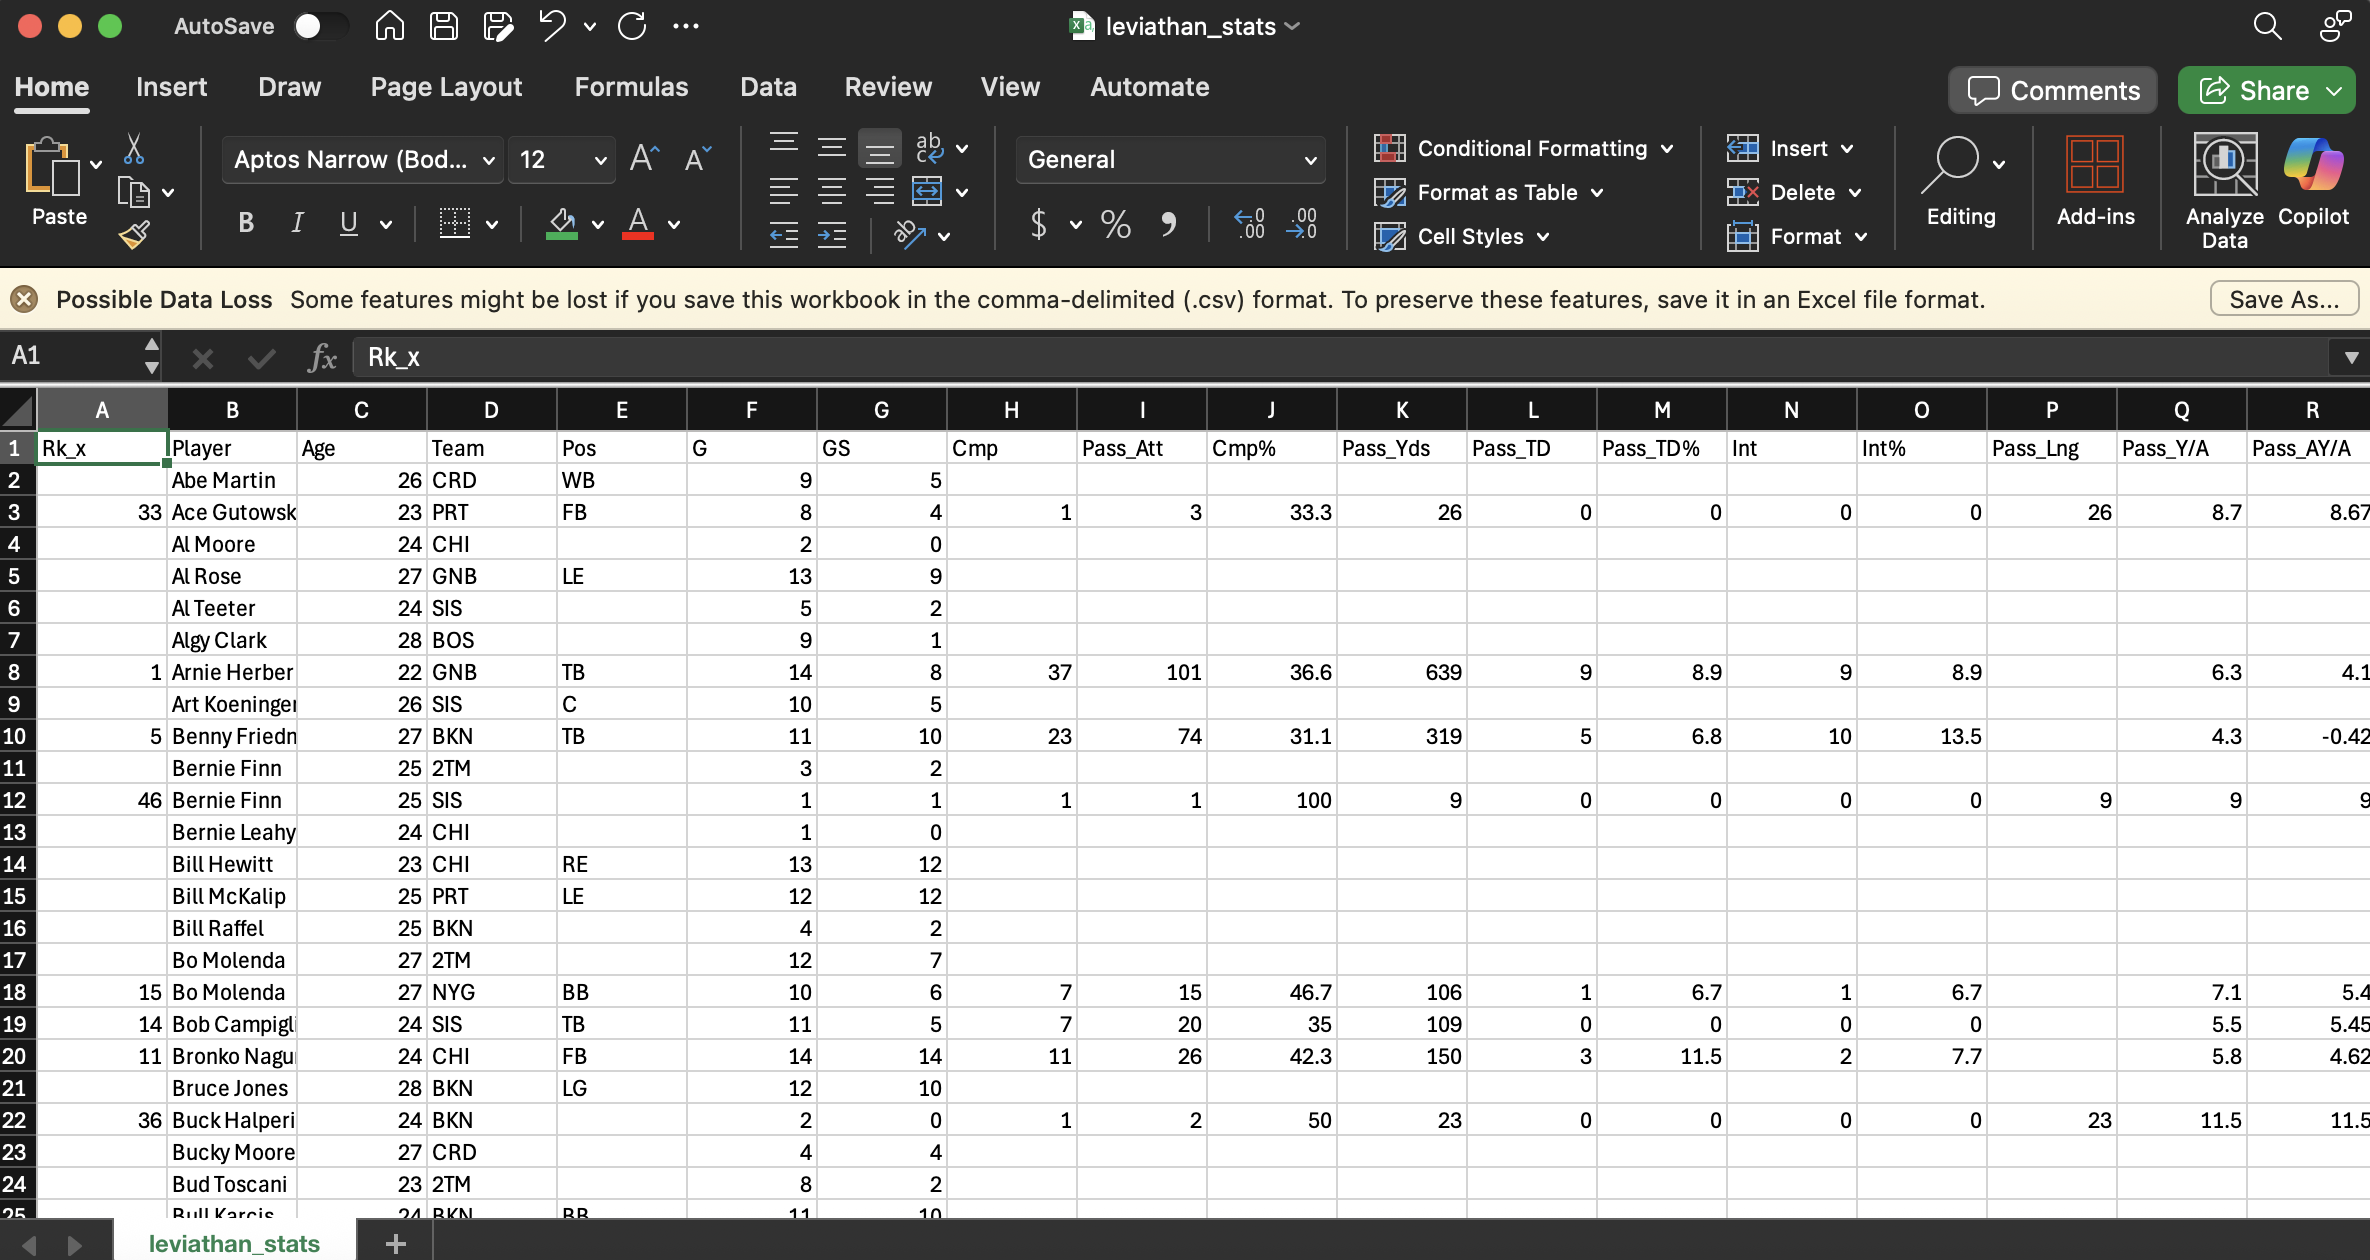

These stats provided me with a strong foundation of features to use. The next step I needed to complete was to get my dependent variable, PPR points scored, and add it to my CSV file.

# Scraping Fantasy Points

One thing I considered is just manually adding a column for PPR fantasy points using a formula based on the scoring system I outlined above. The problem with this is that in its passing, rushing, and receiving stats, Pro Football Reference only includes a column for fumbles but does not include a separate column specifying the number of fumbles lost. In standard fantasy football scoring, a player only loses points for a fumble if the fumble is "lost" (i.e. the other team recovers it); if his own team recovers his fumble, he would not lose points. As a result, if I calculate fantasy points manually, the totals will be somewhat different from what players actually scored under normal rules. While the difference likely wouldn't have been substantial given that each fumble lost only subtracts 2 points from a players points scored and players generally don't fumble more than a few times in a season, I still wanted to ensure that my model was built using the exact number of PPR points players actually scored, avoiding even small deviations.

Fortunately, Pro Football Reference also stores fantasy points scored in a separate location on their website, and because I built my get_stats_csv function to be fairly modular, I was able to leverage it to also get fantasy data.

Citation:
    See, e.g., Pro-Football-Reference.com. (n.d.). 2024 NFL fantasy statistics [Data set]. Retrieved June 1, 2025, from https://www.pro-football-reference.com/years/2024/fantasy.htm (fantasy statistics from other seasons can be accessed by replacing "2024" with the applicable year in this URL).

In [ ]:
def get_fantasy_stats(year):
    """Get fantasy stats for the specified year.

    Args:
        year: An integer representing the year to get fantasy stats for.
    
    Returns:
        Null. Calls get_stats_csv and writes the results to a CSV file.
    """
    stats_type = 'fantasy'
    output_dir = '../fantasy_stats'
    get_stats_csv(year, stats_type, output_dir)

Unfortunately, it turned out that PFR only has fantasy data going back to 1970, so for all seasons prior to that, I did end up having to use the manual calculation option.

In [ ]:
start_year = 1970
end_year = 2024

for yr in range(start_year, end_year + 1):
    print(f'Starting fantasy stats download for year {yr}...')
    get_fantasy_stats(yr)
    print(f'Pausing for a few seconds...')
    # Delay and jitter the requests to PFR to lessen the likelihood of getting rate-limited.
    time.sleep(random.uniform(5.5, 10.5))

I used the below function for manually calculating fantasy points for any seasons prior to 1970.

In [ ]:
def calculate_fantasy_points(df):
    """Calculate PPR fantasy points scored for players in the input dataframe. 

    Args:
        df: A pandas dataframe containing NFL stats.
    
    Returns:
        Column of fantasy point values.
    """
    cols = ['Pass_Yds','Pass_TD','Int','Rushing_Yds','Rushing_TD',
            'Fumbles','Receiving_Rec','Receiving_Yds','Receiving_TD']
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce').fillna(0)

    return (
        df['Pass_Yds']     * 0.04     +          
        df['Pass_TD']      * 4        -          
        df['Int']          * 2        +          
        df['Rushing_Yds']  * 0.10     +          
        df['Rushing_TD']   * 6        -          
        df['Fumbles']      * 2        +          
        df['Receiving_Rec']           +   
        df['Receiving_Yds']* 0.10     +      
        df['Receiving_TD'] * 6            
    )

The below code joins all of the fantasy stat CSVs into a combined CSV, only keeping the columns that are not duplicative of the stat sheets I scraped earlier and using calculate_fantasy_points to manually add fantasy points scored for seasons prior to 1970.

In [ ]:
import numpy as np


def join_fantasy_sheets():
    """Join all fantasy stat sheets from 1970 onward in one df.

    Returns: combined dataframe consisting of all fantasy stat sheets.
    """
    start_year = 1970
    end_year = 2024
    dfs = []

    for yr in range(start_year, end_year + 1):
        df = pd.read_csv(f'fantasy_stats/fantasy_stats_{yr}.csv')
        # Remove duplicate header rows that PFR includes every so often in their stat sheets.
        df = df.dropna(subset=['Rk'])
        # Can remove many columns because they are duplicates of columns already contained
        # in the passing, rushing, and receiving stat sheets, but there are some stats in
        # the fantasy sheets that are not contained in the normal stat sheets, so want to
        # keep those.
        cols_to_keep = [
            'Rk', 'Player', 'Tm', 'FantPos', 'Age', 'Fumbles_FL', 'Scoring_TD', 
            'Scoring_2PM', 'Scoring_2PP', 'Fantasy_FantPt', 'Fantasy_PPR', 
            'Fantasy_DKPt', 'Fantasy_FDPt', 'Fantasy_VBD', 'Fantasy_PosRank',
            'Fantasy_OvRank', 'Season_'
        ]
        df = df[cols_to_keep]
        # Rename these columns to be consistent with the corresponding names in the master
        # sheet, because these are the keys that will be used to join these stats to the
        # master sheet.
        df.rename(
            columns={
                'Tm': 'Team',
                'FantPos': 'Pos',
                'Season_': 'Season'
            },
            inplace=True
        )
        dfs.append(df)
    
    complete_df = pd.concat(dfs, axis=0, ignore_index=True, sort=False)

    return complete_df


complete_sheet = join_fantasy_sheets()
leviathan_stats = pd.read_csv('leviathan_stats.csv')
key_cols = ['Team', 'Player', 'Age', 'Season', 'Pos']

merged = (
    leviathan_stats
    .merge(complete_sheet,            
           on=key_cols,         
           how='left',
           suffixes=('', '_cs')  # Make sure suffixes are appropriate; it threw an error without this.       
    )
)
# Handle seasons prior to 1970, which do not have fantasy points data on PFR so it needs to be 
# calculated manually.
merged['Fantasy_PPR'].replace('', np.nan, inplace=True)
needs_ppr_points = merged['Fantasy_PPR'].isna()
merged.loc[needs_ppr_points, 'Fantasy_PPR'] = calculate_fantasy_points(merged.loc[needs_ppr_points])

merged.to_csv('leviathan_stats_fantasy.csv', index=False)

Sample screenshot of the resulting CSV file:

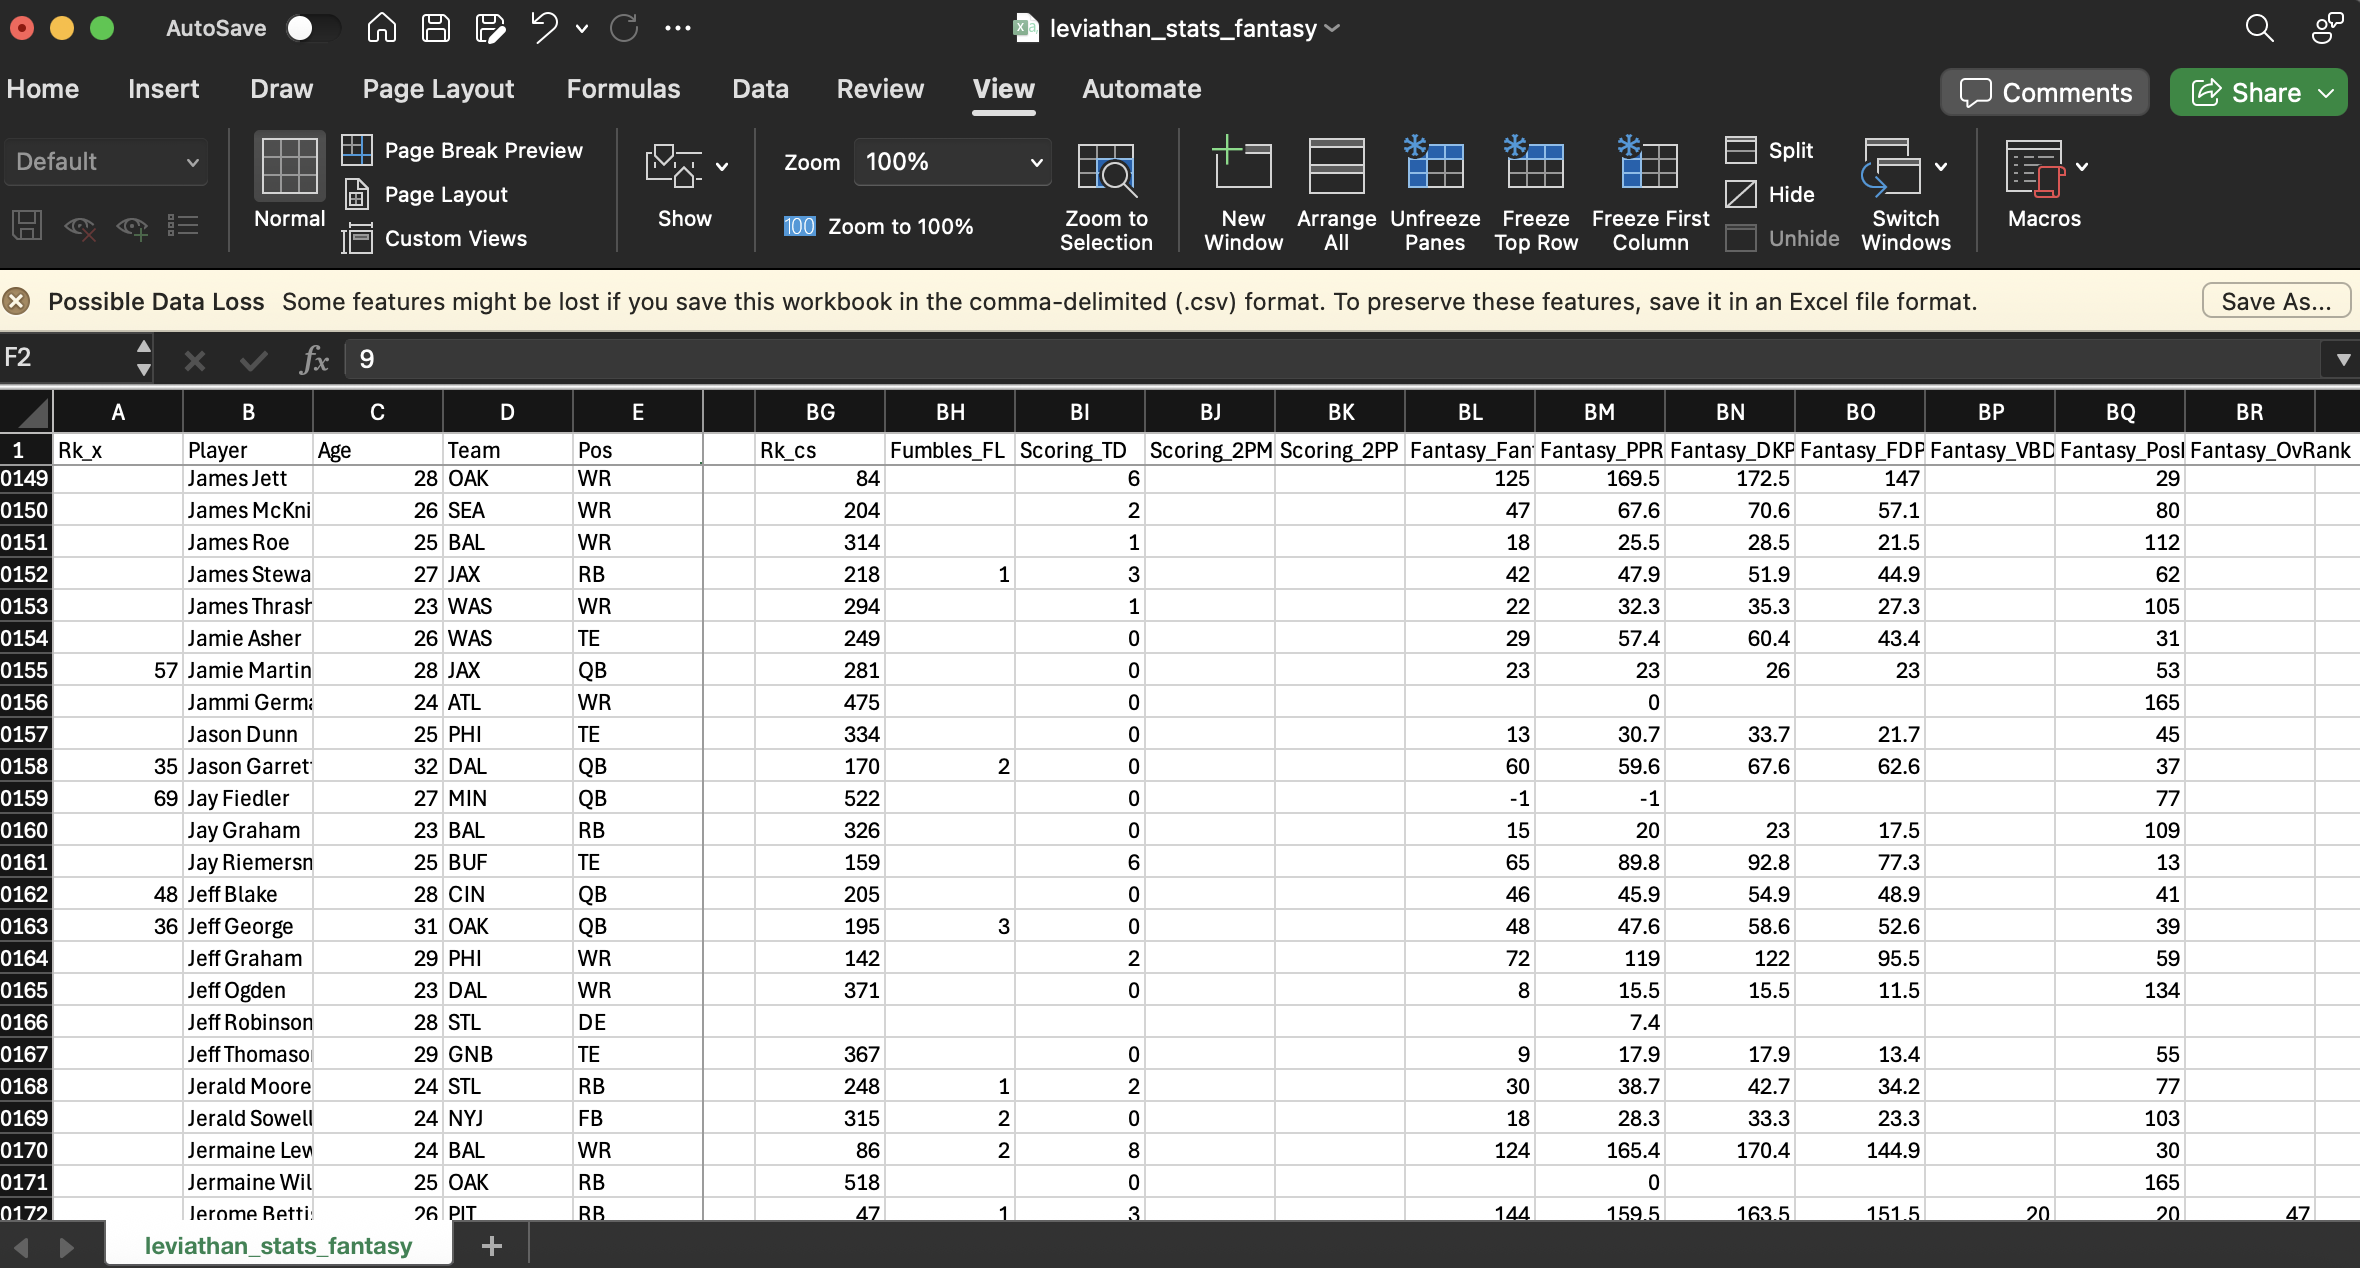

# Add ADP

Once I had a CSV file with both my initial features and dependent variable, I started thinking about other features that I could add to improve the quality of my model. One statistic that I've always found interesting is Average Draft Position, which signifies how early a player is being picked in fantasy drafts. In fact, I had already pulled a lot of this data from Fantasy Pros in connection witha  personal project a few years ago. Looking back at my data, I already have ADP for seasons up to 2022 (Fantasy Pros has PPR ADP data going back to 2012), so I only need to pull the ADP data for the 2023 and 2024 seasons. Given that this is a small amount of data, I just manually copied and pasted it into CSV files (example screenshots below):

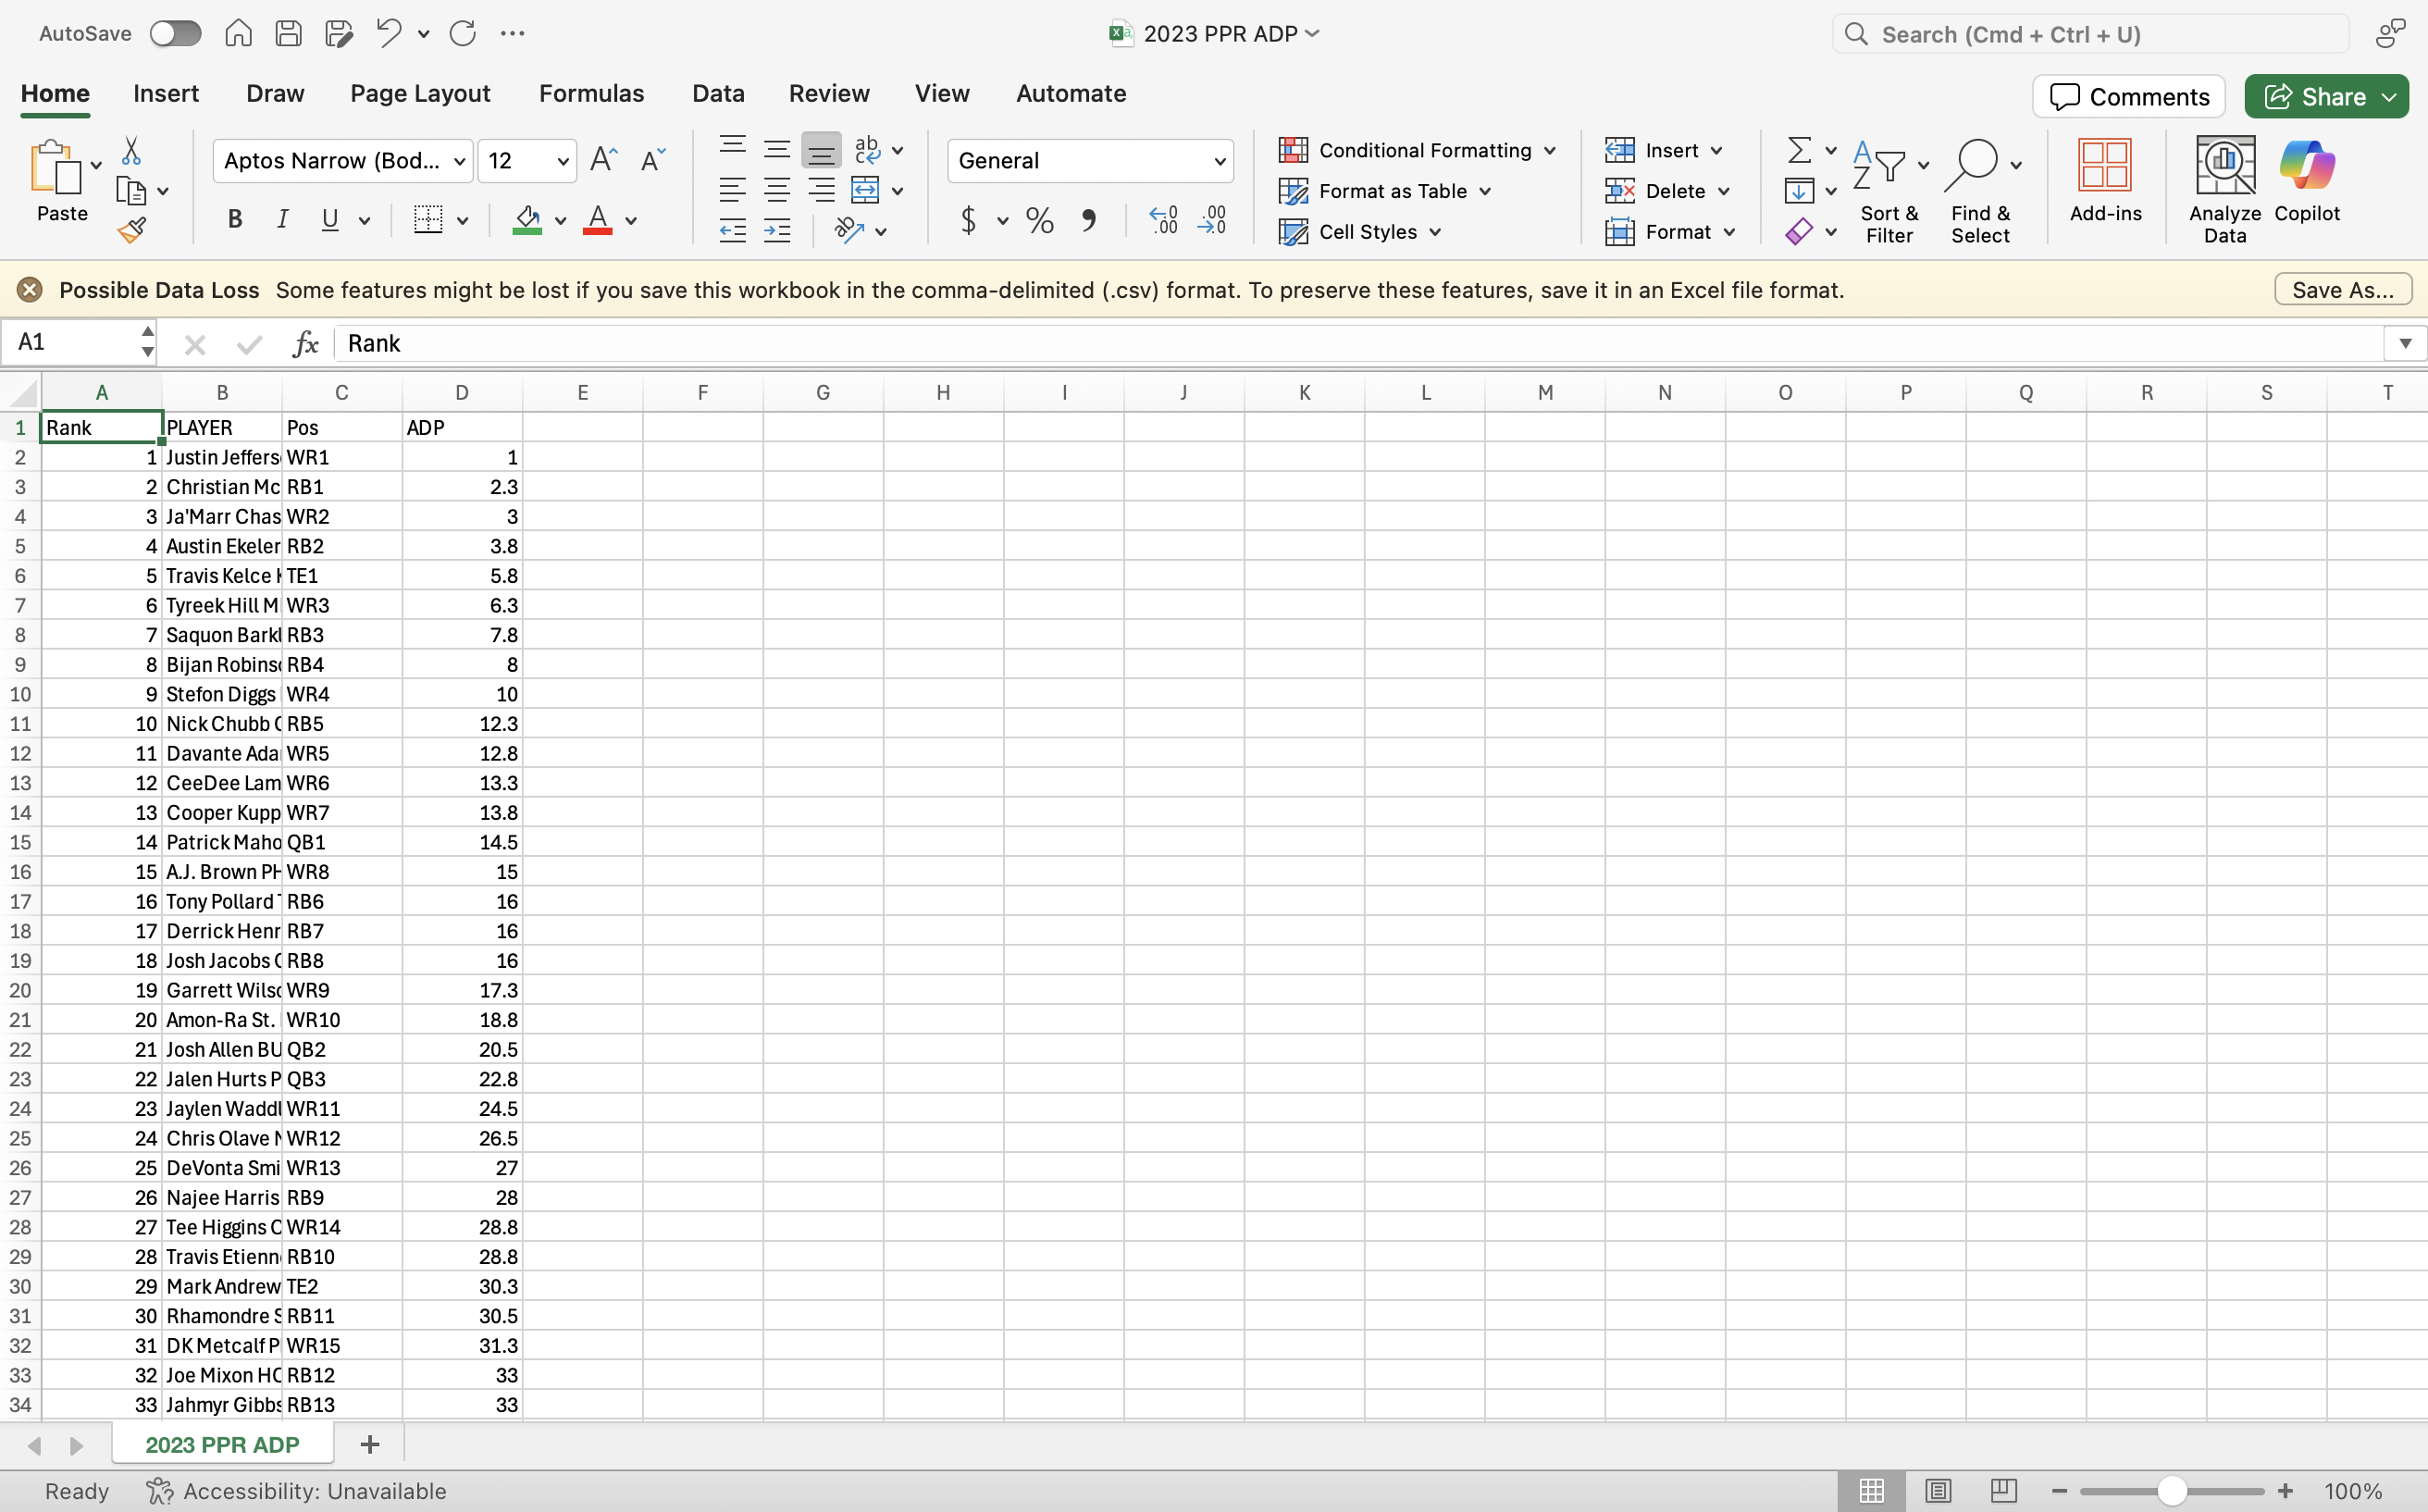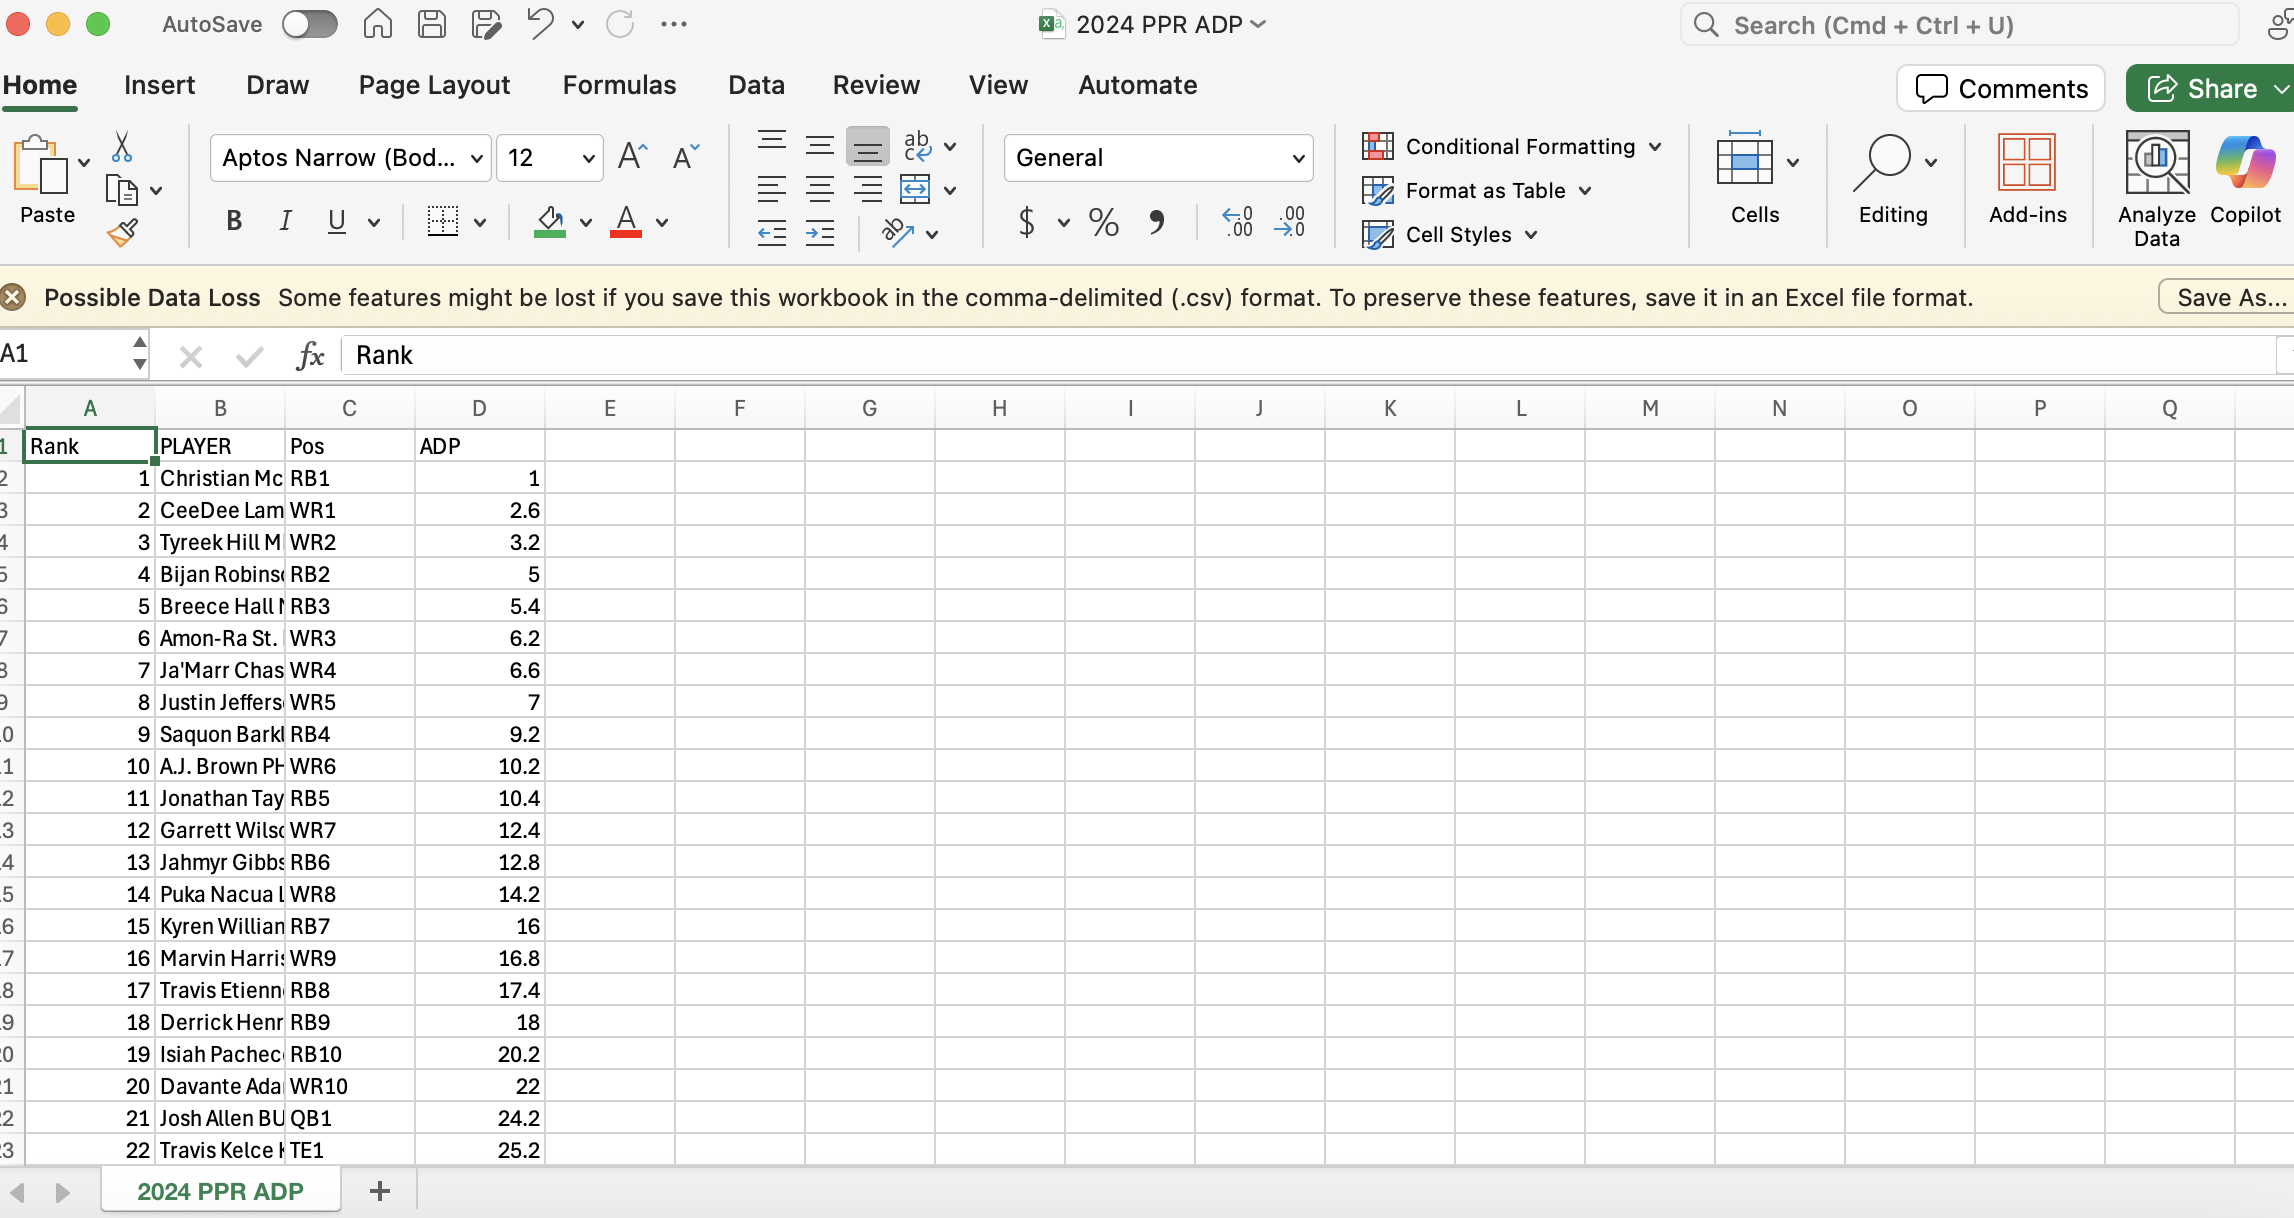

Citation:

See, e.g., Fantasy Pros. (n.d.). 2024 PPR Average Draft Position (ADP) [Data set]. Retrieved June 4, 2025, from https://www.fantasypros.com/nfl/adp/ppr-overall.php?year=2024 (PPR ADP from other seasons can be accessed by replacing "2024" with the applicable year in this URL).


I used the following code to clean the ADP files and consolidate them into one file. Note that much of this is code that I wrote a few years ago so is a bit less organized than the code I used for scraping and cleaning the statistics above.

In [ ]:
import re

years = range(2012, 2025)
list_of_dataframes = []
# Read ADP info for each year into a separate dataframe.
for year in years:
    # I had issues with the encoding of the CSV files after pasting in the data, so I ended up
    # having to iterate over a few different encodings and try each of those to be able to read
    # the files.
    for enc in ['cp1252', 'latin-1', 'iso-8859-1']:
        try:
            df = pd.read_csv('ADP With Position/' + str(year) + ' PPR ADP.csv', encoding=enc)
            break                
        except UnicodeDecodeError:
            pass
    # The ADP files do not contain a column specifying the season that the data is from, so add
    # it here.
    df['Year'] = year
    # Rename position column to ensure conformity with statistics file (this will be one of the
    # keys that I will join on).
    if 'POS' in df.columns:
        df.rename(columns = {'POS':'Pos'}, inplace = True)
        
    list_of_dataframes.append(df)

final_df = pd.concat(list_of_dataframes).reset_index(drop=True)
# Many of the player names contain extraneous data like team names and injury designations in 
# parentheses at the end of their names, so use Regex to strip out text in parentheses from 
# player names.
stripped_names = []

for idx, row in final_df.iterrows():
    stripped_names.append(re.sub(r"\(.*\)", "", str(row['PLAYER'])))
    
final_df['PLAYER'] = stripped_names


def strip_whitespace(column_name, df):
    """Strip trailing whitespace from the specified column

    Args:
        df: A Pandas dataframe.
        column_name: A string representing the name of the column to be cleaned.

    Returns:
        Null. Sets the specified column equal to the cleaned data.
    """
    stripped_whitespace = []
    for idx, row in df.iterrows():
        stripped_whitespace.append(row[column_name].strip())
    df[column_name] = stripped_whitespace


strip_whitespace('PLAYER', final_df)
# Some of the ADP data contains injuries and other extraneous characters appended
# to player names that are not in parentheses, so the previous code for stripping
# text in parentheses will not be sufficient. Best approach I could think of here
# was to go through and list out each unique instance of this that I saw and then
# define some functions to strip these specific strings from player names.
injuries = ['Knee Surgery', 'Hip Surgery', 'Torn ACL', 'Arrested',
            'Torn Achilles', 'Dislocated Hip', 'Broken Leg', 'COV-IR',
            'O', 'IR', 'AK', 'HU', 'N', 'C', 'S', 'WA', 'K', 'CI', 'JA',
            'MI', 'DE', 'TE']


def strip_string(str_to_strip, slice_of_str):
    """Remove the specified slice from the specified string.

    Args:
        str_to_strip: The string to be cleaned.
        slice_of_str: The slice of text to be removed from the string.

    Returns:
        str_to_strip with slice_of_str removed from the end of it.
    """
    if str_to_strip.endswith(slice_of_str):
        s1 = slice(-len(slice_of_str))
        str_to_strip = str_to_strip[s1]
        
    return str_to_strip 


def strip_df(string, df):
    """Iterate over player names and remove the specified string.

    Args:
        string: The string to be stripped from player names.
        df: A Pandas dataframe containing player names.

    Returns:
        Null. Sets the player name column to contain the cleaned names.
    """
    stripped_entries = []
    
    for idx, row in df.iterrows():
        stripped_entries.append(strip_string(row['PLAYER'], string))
        
    df['PLAYER'] = stripped_entries


for injury in injuries:
    strip_df(injury, final_df)
# Some player names also contain bye week information, represented by a comma
# followed by an integer representing the player's bye week in the given season.
# The below code stores player names in a temporary dataframe and strips this information.
temp = final_df['PLAYER']
temp_series = temp.squeeze()
final_df['PLAYER'] = temp_series.str.rstrip(', 0123456789')
# Given that whitespace was stripped above, there shouldn't be any, but given the amount of 
# cleaning that has been done to player names, strip whitespace again as a safety check.
strip_whitespace('PLAYER', final_df)
# Player names also sometimes contain their team abbreviation, so that needs to be stripped too. 
# Note that 'O' is included because 'AK' gets stripped from 'OAK' above in injuries.
teams = ['PHI', 'DAL', 'WAS', 'NYG', 'DET', 'GB', 'MIN', 'CHI', 'NO',
         'TB', 'CAR', 'ATL', 'ARI', 'SEA', 'SF', 'LAR', 'STL', 'NE',
         'MIA', 'NYJ', 'BUF', 'CIN', 'CLE', 'PIT', 'BAL', 'TEN', 'HOU',
         'IND', 'LA', 'JAC', 'KC', 'DEN', 'SD', 'LAC', 'OAK', 'LV', 'O', 
         'FA']

for team in teams:
    strip_df(team, final_df)
# Strip any leftover underscores, and to be safe, strip whitespace one more time. 
strip_df('_', final_df)
strip_whitespace('PLAYER', final_df)
# Rename the ranking column for clarity because there is already a 'Rank' column in the statistics
# sheet.
final_df.rename(columns={'Rank': 'Ovr_ADP_Rk'}, inplace=True)
# In the ADP sheets, player positions and their positional ranks are combined in the format 'QB7',
# 'WR13', etc., so split position and positional rank into separate columns.
final_df[['Pos', 'Pos_ADP_Rk']] = final_df['Pos'].str.extract(r"([A-Z]+)\s*(\d+)", expand=True)
# Some of the sheets have extraneous rows where the Player name is NaN or is just a single
# letter like P or Q. The below code removes these rows.
final_df = (
    final_df.loc[~final_df['PLAYER'].str.fullmatch(r"[A-Za-z]", na=False)]
      .dropna(subset=['PLAYER', 'ADP'])
      .copy()
)

final_df.to_csv('adp.csv')

After getting ADP data into a combined CSV file, I needed to join it to the file containing the statistics and fantasy data that I previously put together. One issue I ran into is that some of the player names in the ADP file are slightly different from how they appear in the statistics file. For example, 'Steve Smith Sr.' in the statistics file is just 'Steve Smith' in the ADP file, and 'A.J. Dillon' in the statistics file is 'AJ Dillon' in the ADP file. Consequently, I wrote a function to standardize the names for the join to work.

In [ ]:
from unicodedata import normalize as unormalize 

RX_INITIAL  = re.compile(r"\b([A-Z])\.\s*")                     
RX_SUFFIX   = re.compile(r"\s+(jr|sr|ii|iii|iv|v|vi)\.?$", re.I)
RX_MULTISP  = re.compile(r"\s+")


def normalize_player(raw):
    """Cleans and normalizes player names to prevent duplicate rows.

    Args:
        raw: A string representing a player's name.
    
    Returns:
        A string with the player's name cleaned and normalized. Removes periods from 
        initials, removes suffixes, makes player names lowercase, etc.
    """
    # Ignore NaNs.
    if pd.isna(raw):                    
        return raw
    # Handle odd unicode charaters: ẞ -> SS, é -> e, …
    s = unormalize('NFKD', raw) 
    # Remove dots from initials.        
    s = RX_INITIAL.sub(r'\1', s)
    # Remove any stray periods.       
    s = s.replace('.', '')  
    # Strip name suffixes like Jr., Sr., II, III, etc.            
    s = RX_SUFFIX.sub('', s)
    # Collapse whitespace.
    s = RX_MULTISP.sub(' ', s)  
    # Make names case-insensitive.      
    return s.casefold().strip()         

From there I was able to add the ADP data to the main statistics file using the below code.

In [ ]:
def add_adp(main_sheet, adp_sheet):
    """Add ADP data to my main stats sheet.
    
    Args:
        main_sheet: A Pandas dataframe containing NFL statistics from Pro Football Reference.
        adp_sheet:  A Pandas dataframe containing average draft position data from FantasyPros.
    
    Returns:
        The combined dataframe that results from performing an outer join on the two 
        sheets on player name, position, and season.
    """
    main_df = pd.read_csv(main_sheet)
    adp_df = pd.read_csv(adp_sheet)
    # Remove extraneous text that starts with a square root symbol and also strip white space.
    adp_df['Player'] = (
        adp_df['Player']
        .str.replace(r"[^A-Za-z.\-'\s].*$", "", regex=True)  
        .str.rstrip()                                    
    )

    for df in (main_df, adp_df):
        df['_name_key'] = df['Player'].map(normalize_player)

    keys = ['_name_key', 'Pos', 'Season']
    # Use an outer join because I want to keep any players who were drafted but who did not end up
    # accumulating any statistics for one reason or another.
    combined = pd.merge(
        main_df,
        adp_df,
        left_on=keys,
        right_on=keys,
        how='outer',
        suffixes=('_main', '_adp'),
    )
    # When the sheets are merged, the names of any players from the ADP sheet who are 
    # not in the main PFR sheet are added as a separate column from the names of the 
    # players in the PFR sheet. This merges those columns so all player names are in one
    # column.
    combined['Player'] = combined['Player_main'].combine_first(combined['Player_adp'])
    combined = combined.drop(columns=['Player_main', 'Player_adp', '_name_key'])

    return combined


adp = 'adp.csv'
leviathan = '../leviathan_stats_fantasy.csv'
combined_df = add_adp(leviathan, adp)
combined_df.to_csv('leviathan_plus_adp.csv', index=False)

After running this code, I still had to do a bit of manual data cleaning because there were a few names that were spelled differently in the two sheets and a few players whose position was listed differently in the main statistics sheet from the ADP sheet. I also had to rearrange the columns a bit so that the player name and season columns were on the left side of the file. After this was done, I had the following updated version of my "leviathan" file with ADP added alongside fantasy points scored and NFL stats:

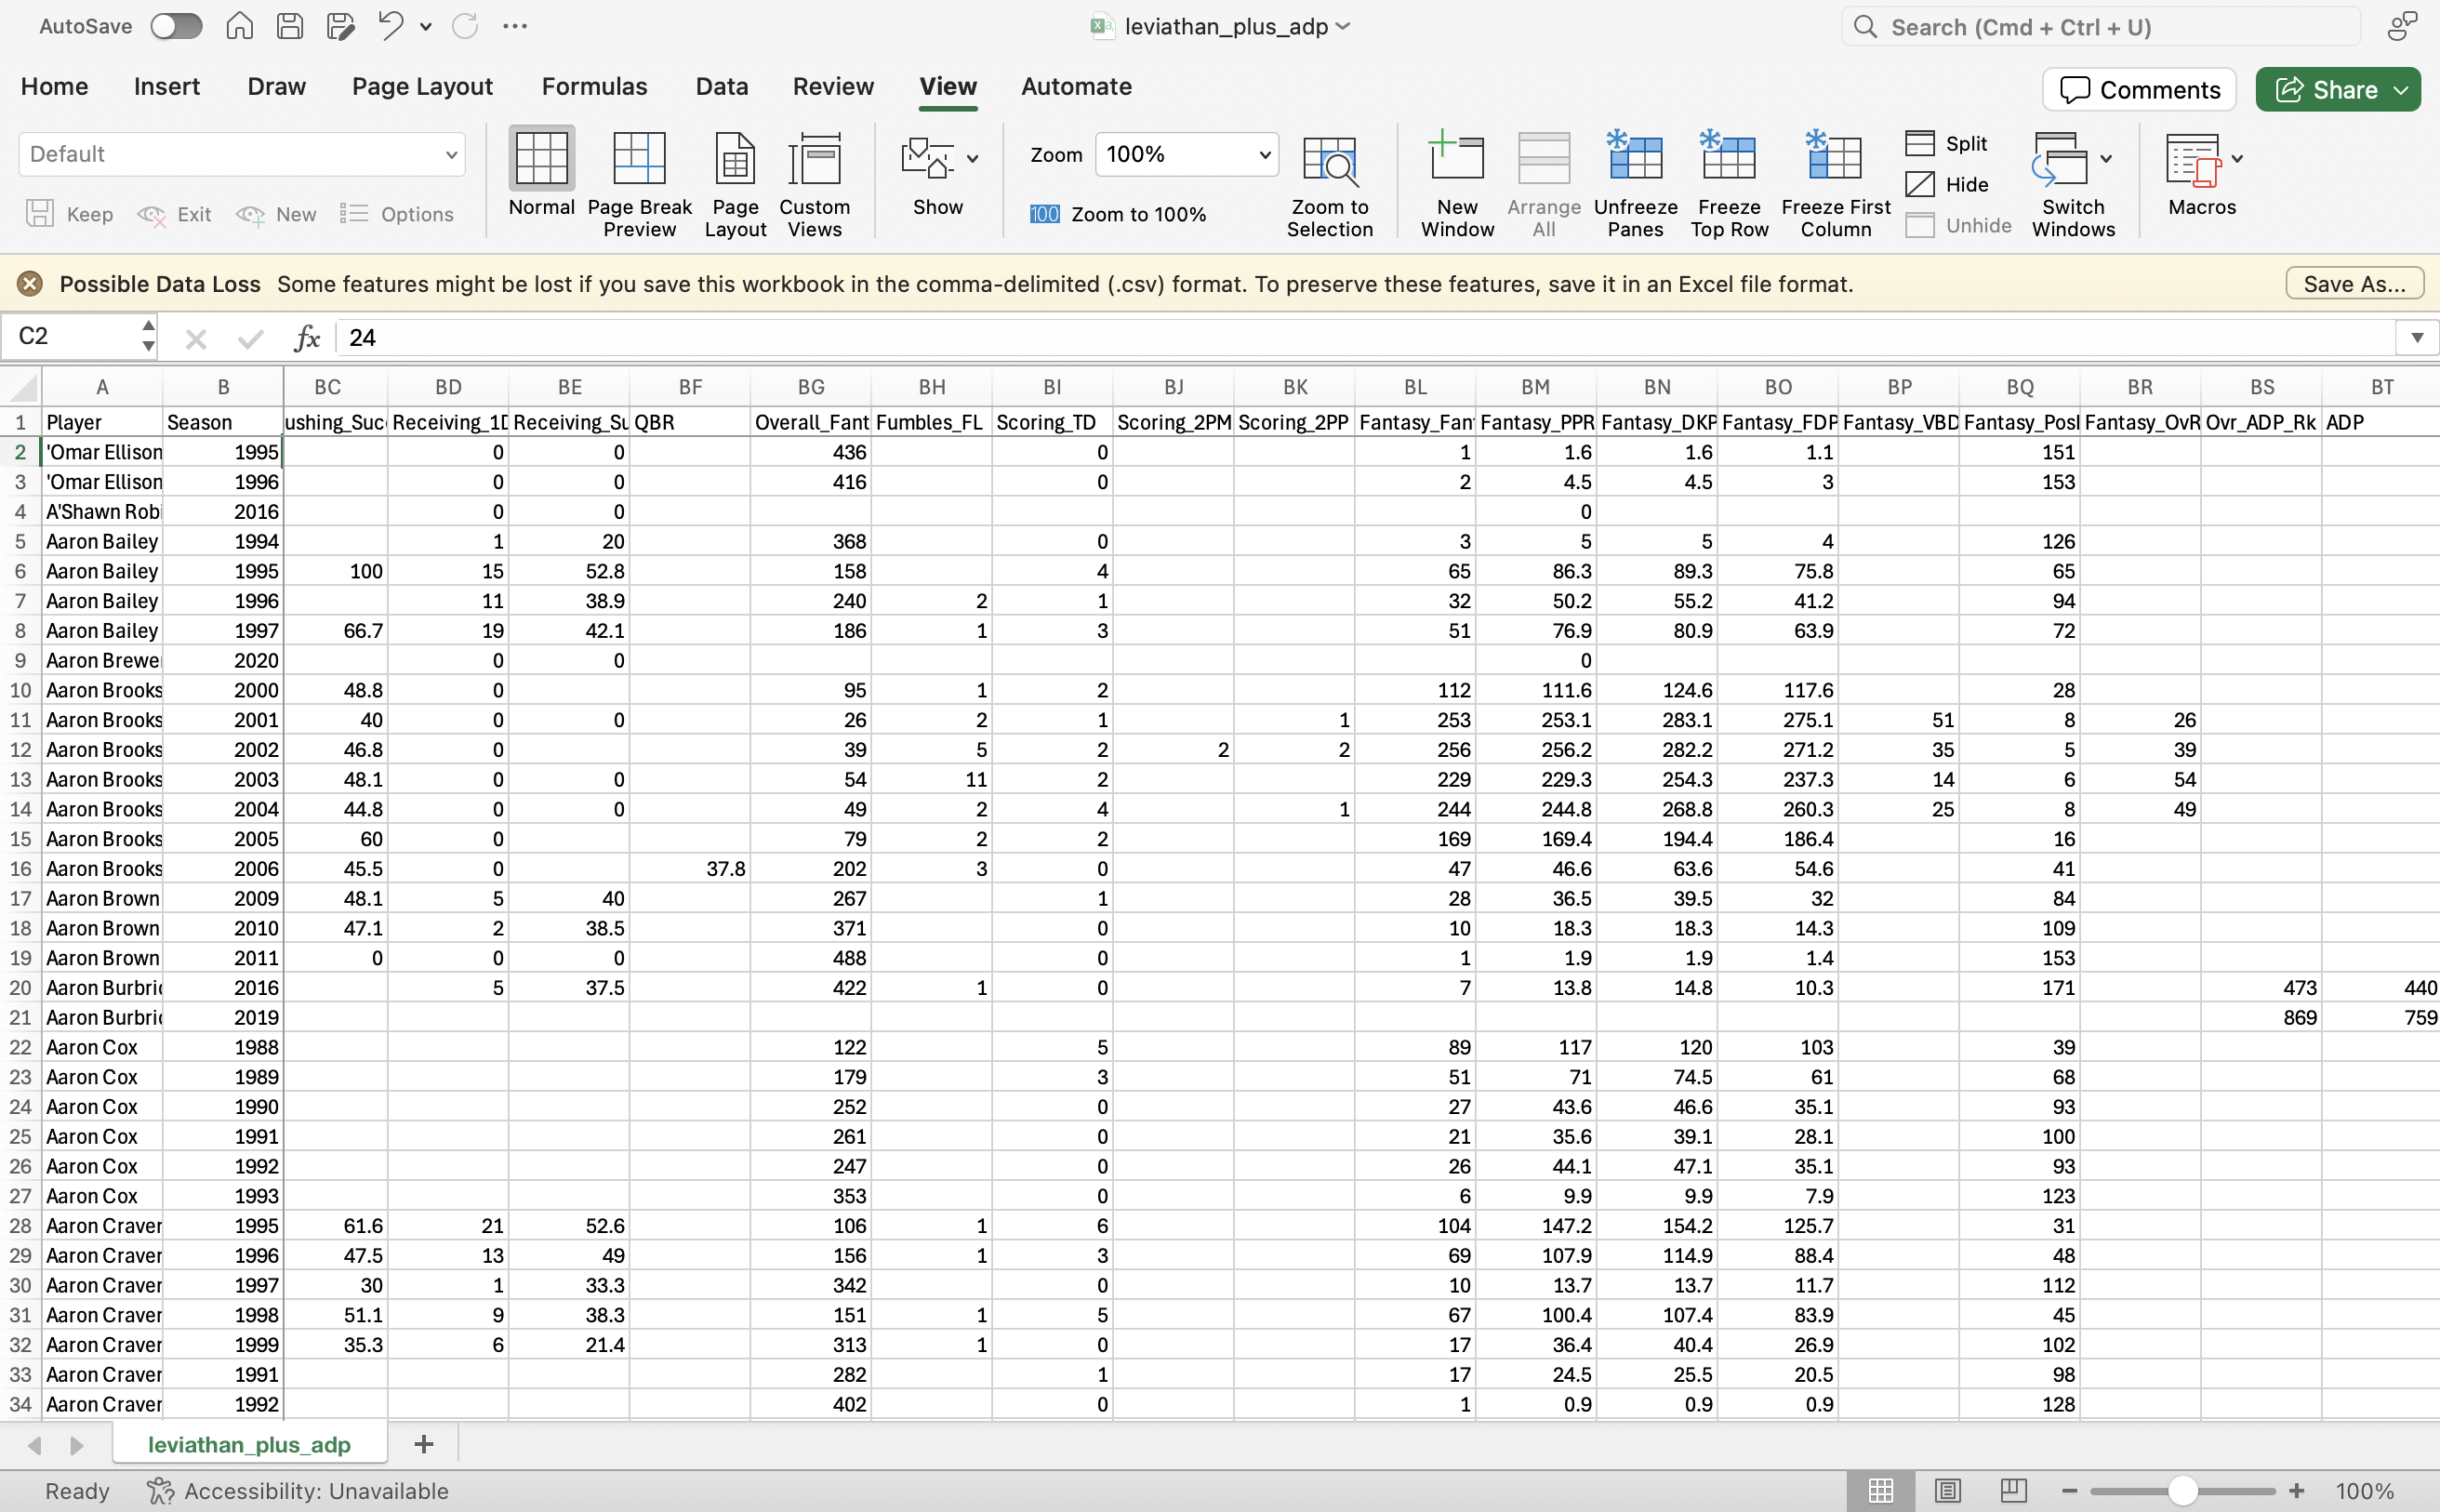

# Get Scouting Combine Data

Something else I wanted to analyze is to what extent NFL Scouting Combine performance correlates to fantasy football performance. Each year, the NFL invites top rookies to the Scouting Combine where they undergo a number of tests, from measuring their hand size to timing their 40 yard dash speed to occasionally testing their intelligence via the Wonderlic test (although they stopped using this test in 2022). These measurements allow NFL teams to evaluate which rookies they want to draft, and I wanted to analyze what effect, if any, they have on fantasy football scoring.

nflcombineresults.com has NFL Scouting Combine data going back to 1987, but I kept getting a 404 error when I tried to scrape it, so I ended up having to copy and paste this data manually into CSV files like the below.

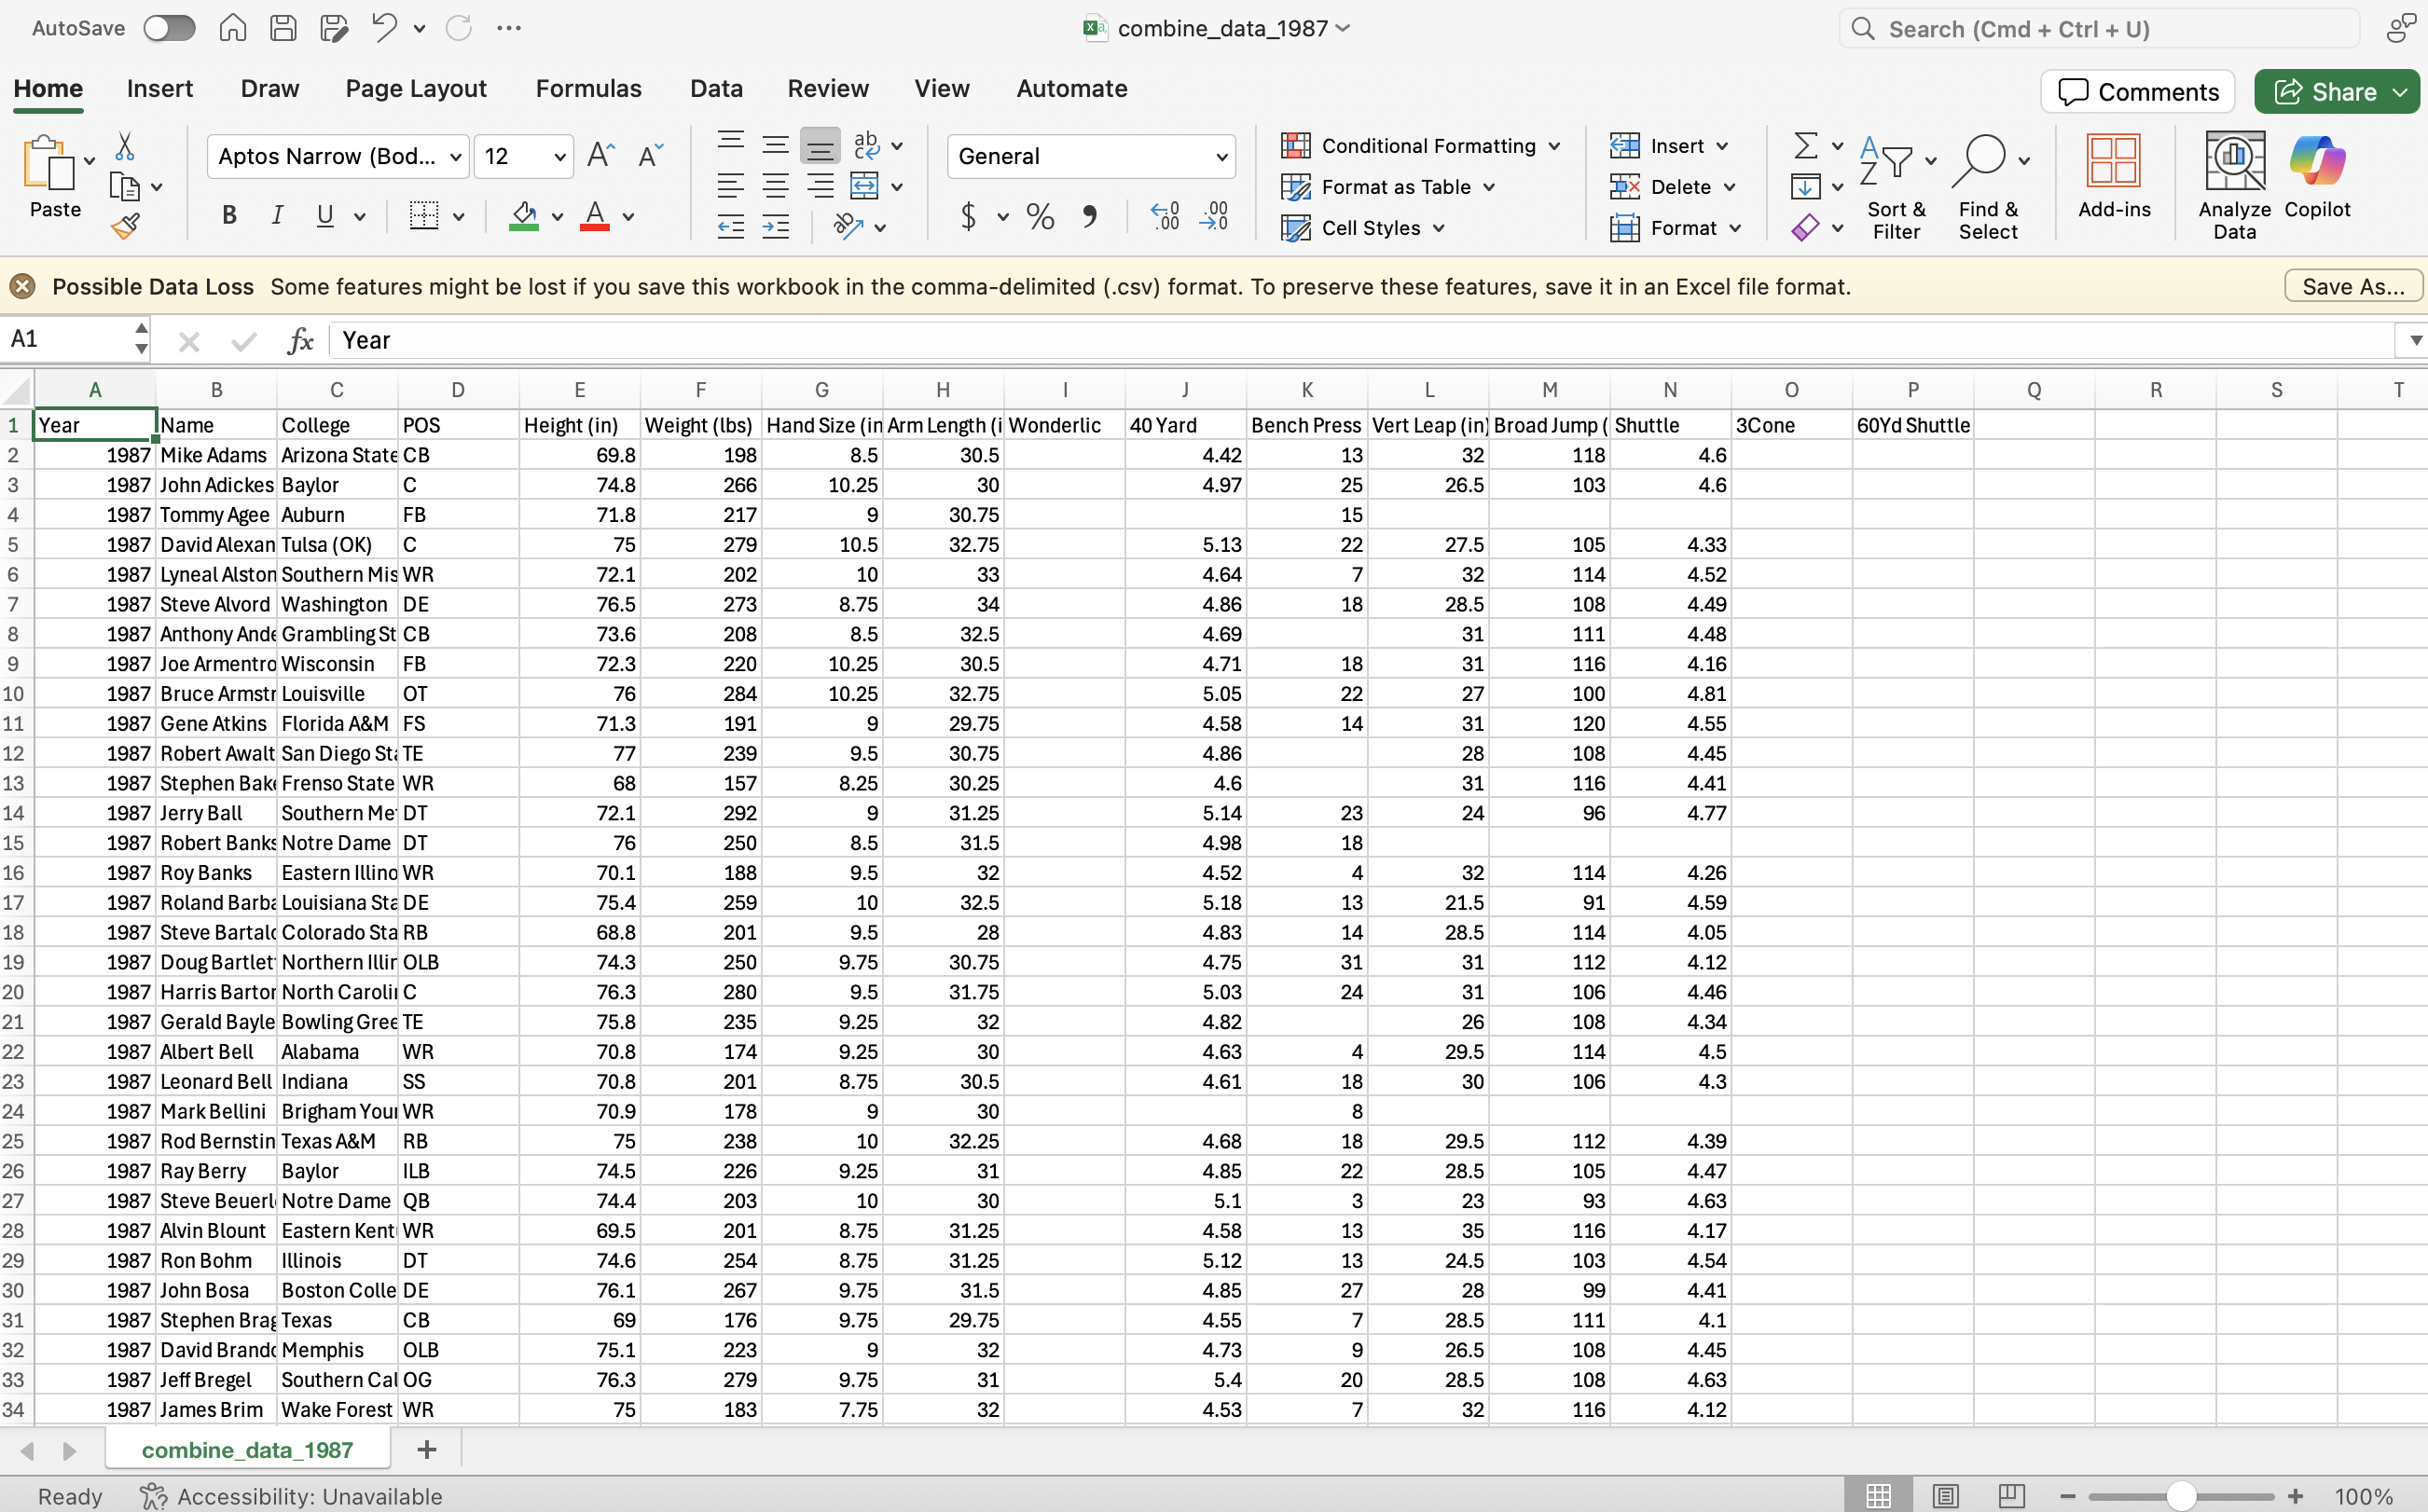

*Imputing Certain Combine Data*

Note that where Scouting Combine data is unavailable, nflcombineresults.com also includes certain measurements from Pro Days. Pro Days are events held by university football programs where NFL scouts are allowed to attend and watch players perform drills similar to those performed at the Scouting Combine. Measurements performed at Pro Days are generally considered to be less accurate than Scouting Combine measurements. nflcombineresults.com provides options to either hide Pro Day measurements or to adjust them based on a per position average difference between Pro Day and Scouting Combine measurements for a given drill. I chose to include but adjust Pro Day measurements, so in essence I imputed some Scouting Combine measurements based on Pro Day data and average differences between Pro Day data and Scouting Combine data.

Citation:

See, e.g., NFL Combine Results. (n.d.). 2024 NFL Combine Data (Expanded and Adjusted) [Data set]. Retrieved June 6, 2025, from https://nflcombineresults.com/nflcombinedata_expanded.php?year=2024&pos=&college=&adjust=on (Scouting Combine data from other seasons can be accessed by replacing "2024" with the applicable year in this URL).

I then wrote the below code to combine them into one CSV file that I could join to my main "leviathan" sheet.

In [ ]:
def concat_combine_data(combine_dfs):
    """Concatenate Scouting Combine data for offensive players into one df.

    Args:
        combine_dfs: A list of dataframes containing NFL Scouting Combine data from 1987 to 2025.

    Returns:
        A dataframe containing NFL Scouting Combine measurements from all offensive players from 1987 to 2025.
    """
    master_df = pd.concat(combine_dfs, axis=0, ignore_index=True, sort=False)
    # For fantasy football purposes, I don't want to include defensive players.
    offensive_positions = {'QB', 'RB', 'FB', 'WR', 'TE',}
    df_offense = master_df[master_df['POS'].str.upper().isin(offensive_positions)].copy()
    df_offense.rename(columns={'Year': 'Season', 'POS': 'Pos', 'Name': 'Player'})   

    return df_offense


start_year = 1987
end_year = 2025

dfs = [
    pd.read_csv(f'combine_csvs/combine_data_{yr}.csv') 
    for yr in range(start_year, end_year + 1)
]

complete_sheet = concat_combine_data(dfs)
complete_sheet.to_csv('full_combine_data.csv', index=False)

One issue that I ran into is that when joining the combine data to the main file is that the only features I could use as keys were player names and positions. When joining ADP and fantasy scoring data, I could also use features like the applicable season and the name of the player's team, but the combine data doesn't have those features. For example, in the 2000's there were two Wide Receivers named Steve Smith: one drafted in 2001 and one drafted in 2007. I wanted to make sure I didn't mix up their combine data when joining the sheets. 

One approach I considered was adding a column called 'first_season' to my main file and adding 'first_season' == 'draft_class' as a key when joining combine data. The problem with this approach is that some players don't play during their rookie season, so their first season may not be the same as the year of their draft class.

To address this, I added some code to find the difference between each player's draft class and their first season and joined the combine data for the player with the smallest gap between draft class and first season.

In [ ]:
def clean_name(player):
    """Lowercase, drop punctuation & extra spaces.
    
    Args:
        player: A string representing a player's name.

    Returns:
        A string representing the player's name that is all lowercase with punctuation
        and extraneous spaces removed.
    """
    return (player.str.lower()
              .str.replace(r'[^a-z\s]', '', regex=True)
              .str.replace(r'\s+', ' ',  regex=True)
              .str.strip())


def add_combine_data(df_stats, df_combine):
    """Join NFL Scouting Combine data to main CSV file.

    Args:
        df_stats: Main Pandas dataframe containing passing, rushing, and receiving
        statistics, average draft position, and fantasy scoring data.

        df_combine: Pandas dataframe containing NFL Scouting Combine data dating back to
        1987.

    Returns:
        Combined dataframe with df_combine joined to df_stats.
    """
    for df in (df_stats, df_combine):
        df['name_clean'] = clean_name(df['Player'])
        df['pos_clean']  = df['Pos'].str.upper().str.strip()
    # Get the earliest season for each player in the main file.
    first_season = (
        df_stats
            .loc[:, ['name_clean', 'pos_clean', 'Season']]
            .groupby(['name_clean', 'pos_clean'])
            .Season.min()               
            .rename('first_season_year')
            .reset_index()
    )
    # Join the "first season" table to the scouting combine sheet.
    candidates = (first_season
                  .merge(df_combine,
                         on=['name_clean', 'pos_clean'],
                         how='left', suffixes=('', '_cmb')))   
    # Calculate how far the applicable combine’s draft year is from a player's first season.
    candidates['year_gap'] = (candidates['first_season_year']
                              - candidates['Season']).abs()
    # For each (name, pos) keep the combine data from the combine with the smallest gap.
    best_match = (candidates
                  .sort_values('year_gap')
                  .drop_duplicates(subset=['name_clean', 'pos_clean'], keep='first'))
    
    df_stats_enriched = (df_stats
        .merge(best_match,
               on=['name_clean', 'pos_clean'],
               how='left')        
    )

    return df_stats_enriched


leviathan = pd.read_csv('../adp/leviathan_plus_adp.csv')
combine_data = pd.read_csv('full_combine_data.csv')
combined_sheet = add_combine_data(leviathan, combine_data)
combined_sheet.to_csv('leviathan_plus_combine.csv', index=False)

As with the ADP data, I still had to do some manual cleaning after adding this data. My strategy of joining the combine data from the year closest to each player's first season was generally successful but did lead to a few errors that I had to correct. However, after addressing those, I was left with a robust dataset containing over 37,000 observations and over 80 potential features to use in my model. An example screenshot is below:

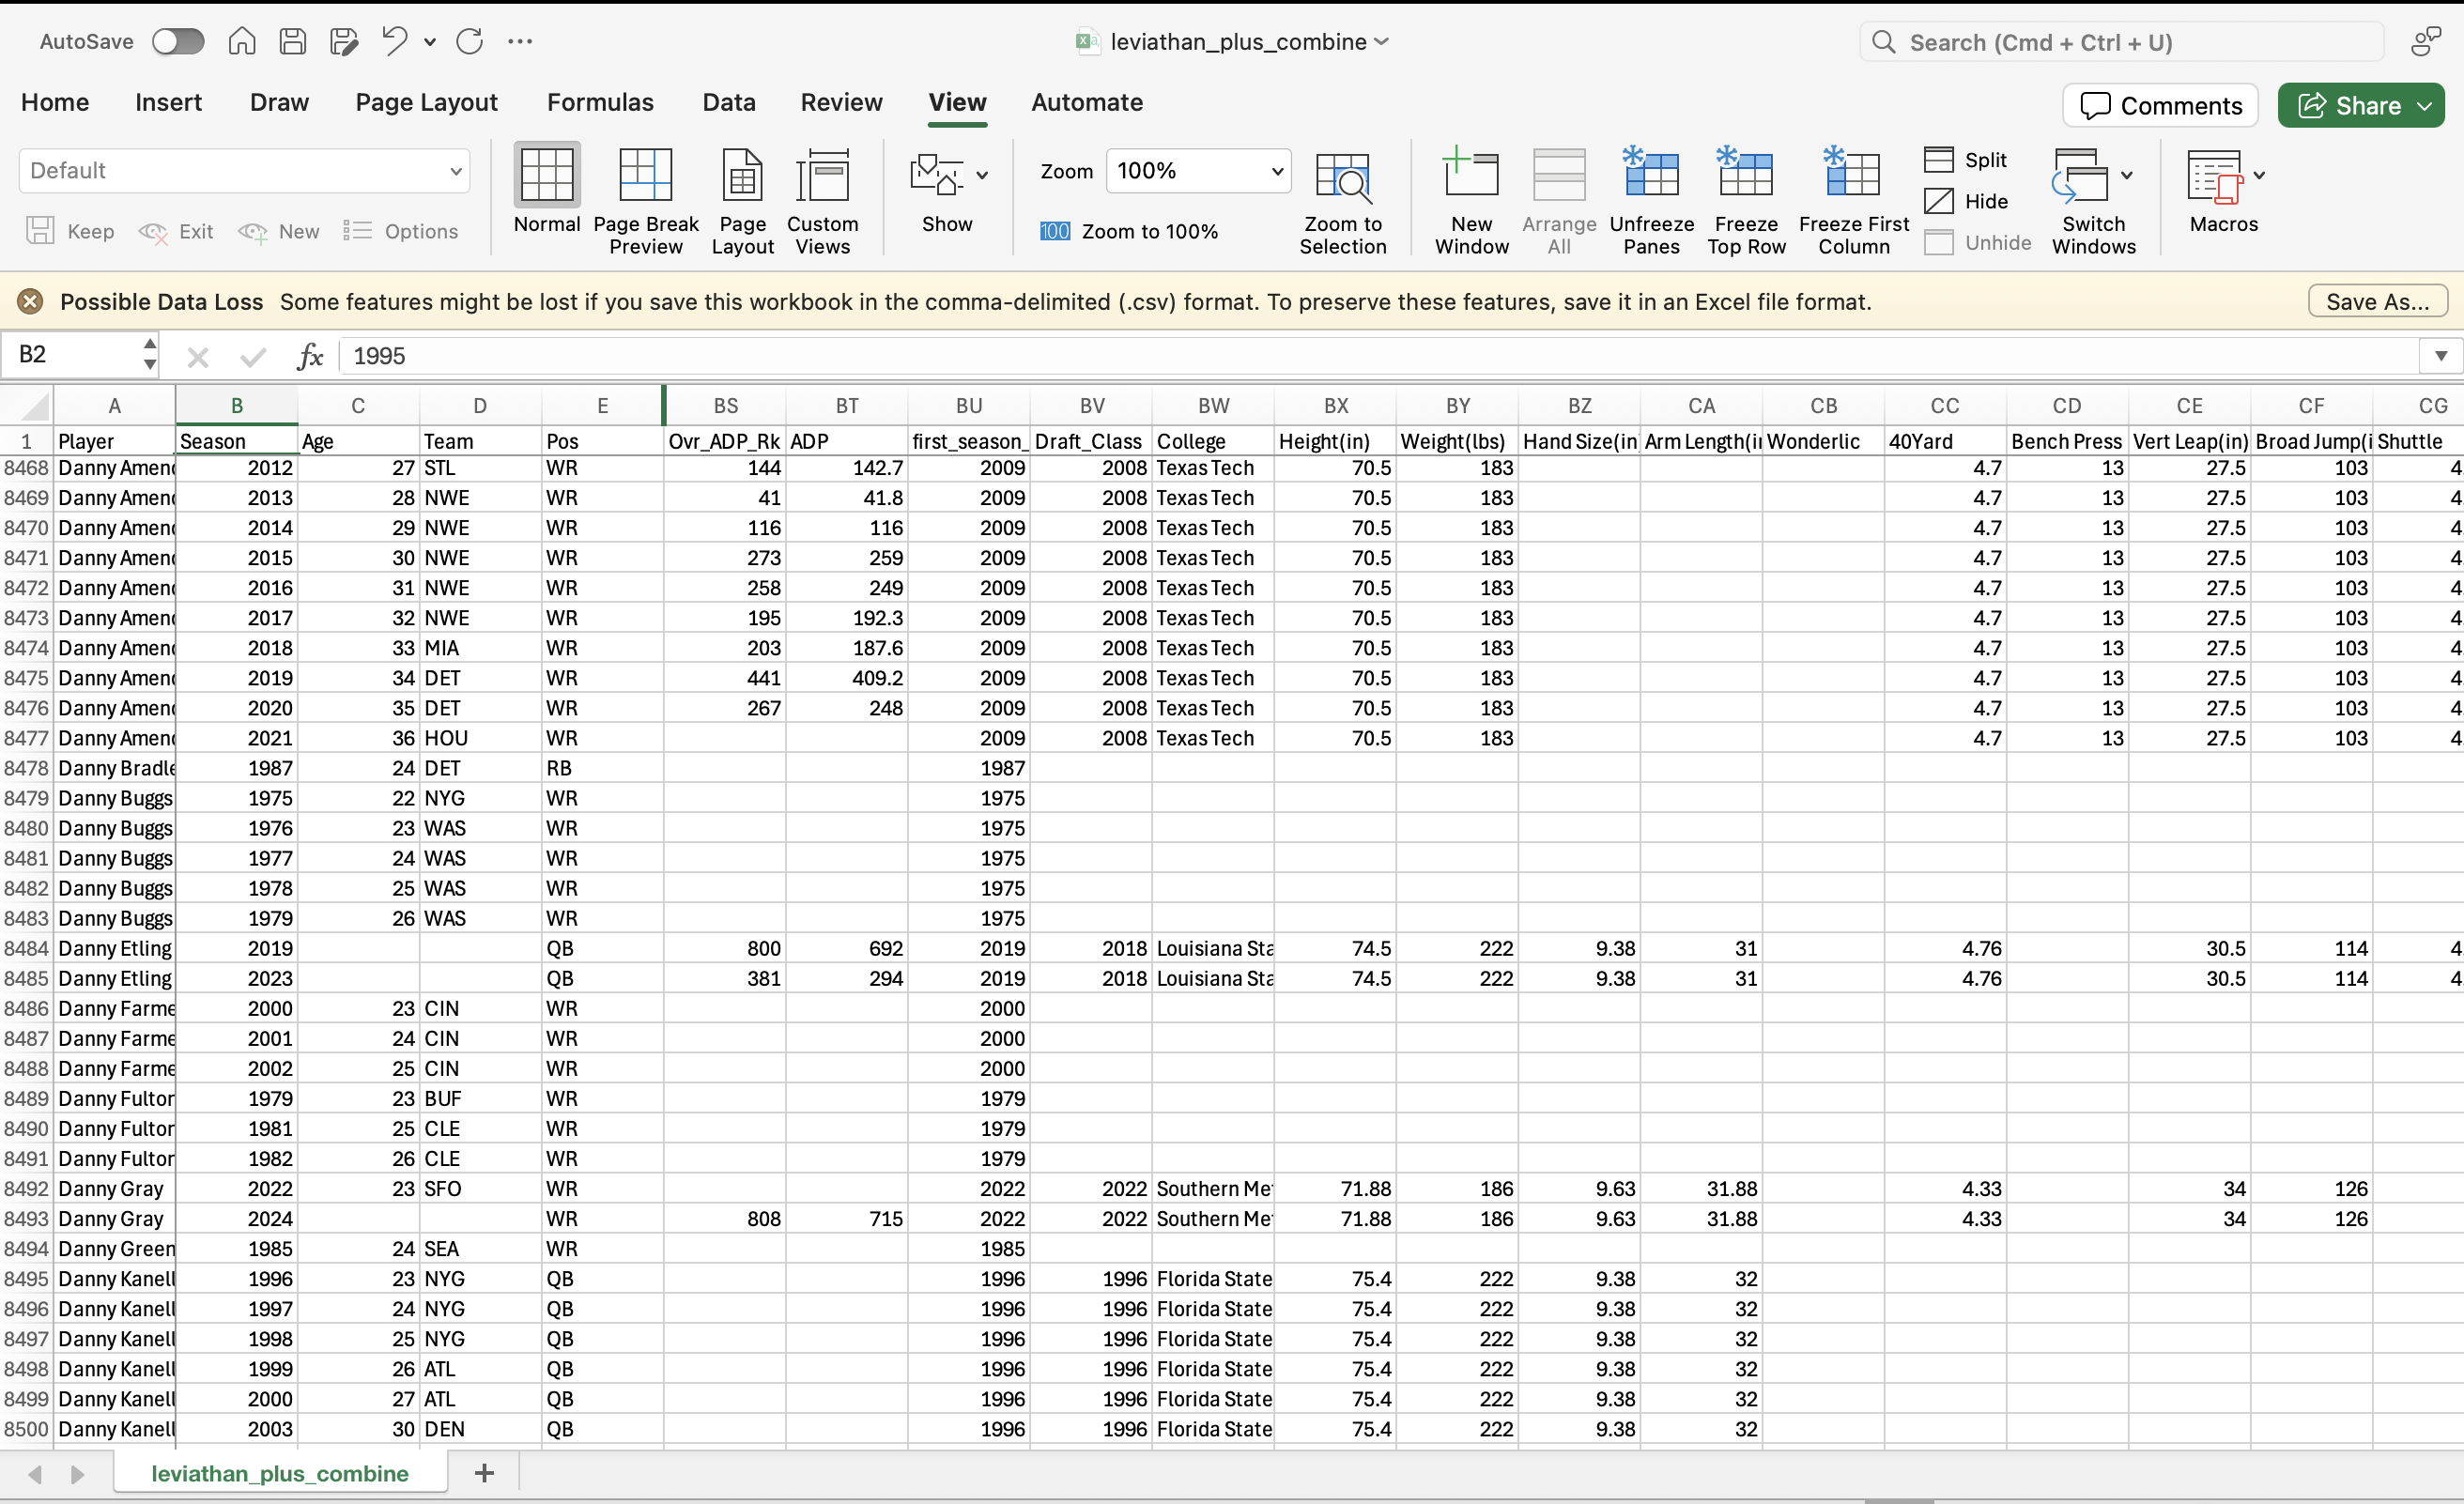

# Data Cleaning Summary and Considerations Going Forward

Putting this dataset together required a bit more data cleaning than I expected. By far the most time-consuming aspect was figuring out how to execute the joins in a way that matched up the joined sheets correctly without creating duplicate rows or losing data. In hindsight, I could have done a better job of thinking through how to handle edge cases like one player having different positions in different sheets (e.g. being listed as a WR by Pro Football Reference but a TE by Fantasy Pros) or having a slight differences in the way their name is spelled across different sheets. Ultimately though, I think it was unavoidable that I was going to have to do some degree of manual cleaning to handle outliers, and that is where I ended up spending the bulk of my time.

Just eyeballing my complete datasheet, I can see that I have a number of sparse features, primarily because each of my key groups of features (season statistics, fantasy points, ADP, and scouting combine data) vary widely in how far they go back. I will need to think about the best way to address this.

I also note that, not surprisingly, different statistics are sparse for different positions. For example, many of the passing features are NaNs for players who are not quarterbacks, while receiving features are mostly NaNs for quarterbacks. Further refinement of my dataset is needed, and I may need to split it up by position, but given that this notebook is getting a bit long, I will save that refinement for the notebook that covers my exploratory data analysis and the implementation of my model.